# Notebook para todas as redes usando BINARIO

In [13]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os# Notebook para todas as redes usando multclasses
import copy 
import cv2
from torch.autograd import Variable
import random
import shutil, sys
import pandas as pd
from PIL import Image
from PIL import ImageFile
#from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [14]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = '/home/jimi/dissertacao/covid19/datasets/bin_80_20/'

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
#model_name = "densenet"

# Number of classes in the dataset
#num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 16

# Number of epochs to train for


# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

#num_epochs = 500

In [15]:
test = 2

In [16]:
# Data augmentation and normalization for training
# Just normalization for validation
#transforms.RandomRotation(degrees=(-5, 5)),
#transforms.ColorJitter(brightness=.02),
    
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'val', 'test']}

# Create training and validation dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                    batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

# trans = ['train','val','test']
# categories = ['train','val','test']

class_names = image_datasets['train'].classes

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

#device.reset()

Initializing Datasets and Dataloaders...
cuda:0


In [17]:
# Path to data
data_dir = '/home/jimi/dissertacao/covid19/datasets/bin_80_20/'
train_dir = data_dir+'train/'
test_dir = data_dir+'test/'
val_dir = data_dir+'val/'

#normal_dir = data_dir+'normal/'
pneumonia_dir = data_dir+'pneumonia/'
covid_dir = data_dir+'covid/'

len_covid = len([iq for iq in os.scandir(covid_dir)])
#len_normal = len([iq for iq in os.scandir(pneumonia_dir)])
len_pneumonia = len([iq for iq in os.scandir(pneumonia_dir)])

len_train_dir = len([iq for iq in os.scandir(train_dir+'covid/')]) + len([iq for iq in os.scandir(train_dir+'pneumonia/')])
len_test_dir = len([iq for iq in os.scandir(test_dir+'covid/')]) + len([iq for iq in os.scandir(test_dir+'pneumonia/')])
len_val_dir = len([iq for iq in os.scandir(val_dir+'covid/')]) + len([iq for iq in os.scandir(val_dir+'pneumonia/')])

print('Files per classes')
print("----"*10)
#print("normal : ", len_normal)

print("pneumonia : ", len_pneumonia)

print("covid : ", len_covid)

print("-"*20)

print('Train, test, validation')

print("-"*20)

print("len_train_dir : ", len_train_dir)

print("len_test_dir : ", len_test_dir)

print("len_val_dir : ", len_val_dir)



Files per classes
----------------------------------------
pneumonia :  4035
covid :  4105
--------------------
Train, test, validation
--------------------
len_train_dir :  6438
len_test_dir :  29
len_val_dir :  1610


In [18]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, 
                model_name, lr, batch_size, opt_name, crt_name):
    since = time.time()
    is_inception = False
    
    #tensorboard
    #writer = SummaryWriter(f'runs/dg_{model_name}_lr={lr}_epoch={num_epochs}_batch_size={batch_size}')
    step = 0

    val_acc_history = []
    val_loss_history = []
    
    train_acc_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        print('-' * 10)
        

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            

            #writer.add_scalar('training loss', loss, global_step=step)
            #writer.add_scalar('training accuracy', epoch_acc, global_step=step)
            step += 1
            
            #only to plot the graph
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

        print()
        
        
    time_elapsed = time.time() - since
    print()
    print('#'*30)
    print('------ Summary ------')
    print(f'model -> {_model}')
    print(f'epochs -> {_epochs}')
    print(f'lr -> {_lrs}')
    print(f'batch size -> {_batch}')
    print(f'optimizer -> {opt_name}'), 
    print(f'criteriun -> {crt_name}')
    print()
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('#'*30)
    
    plt.figure(figsize=(13, 4))
    plt.subplot(1, 2, 1)
    plt.plot(val_acc_history, label="Validation Accuracy")
    plt.plot(train_acc_history, label="Validation Loss")
    plt.title('Accuracy in Validation Dataset')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(val_loss_history, label="val_loss_history")
    plt.plot(train_loss_history, label="train_loss_history")
    plt.title('Loss in Validation Dataset')
    plt.legend()
    plt.tight_layout()
    plt.savefig('hist_'+_model+'_opt_'+opt_name+'_crt_'+crt_name+'.png')
    plt.show()

    print()

    print('==== END ====')


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [19]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 3, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [20]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [21]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "shufflenet":
        """ shufflenet
        """
        model_ft = models.shufflenet_v2_x1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        
    elif model_name == "mobilenet":
        """ mobilenet
        """
        model_ft = models.mobilenet_v2(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        
    elif model_name == "googlenet":
        """ googlenet
        """
        model_ft = models.googlenet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [22]:
import itertools 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('cm_'+title+'.png')


==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.3922 Acc: 0.8521
val Loss: 0.2002 Acc: 0.9522

Epoch 1/99
----------
train Loss: 0.1753 Acc: 0.9553
val Loss: 0.1320 Acc: 0.9714

Epoch 2/99
----------
train Loss: 0.1337 Acc: 0.9630
val Loss: 0.1122 Acc: 0.9733

Epoch 3/99
----------
train Loss: 0.1139 Acc: 0.9705
val Loss: 0.0881 Acc: 0.9851

Epoch 4/99
----------
train Loss: 0.1008 Acc: 0.9734
val Loss: 0.0790 Acc: 0.9863

Epoch 5/99
----------
train Loss: 0.0933 Acc: 0.9753
val Loss: 0.0726 Acc: 0.9870

Epoch 6/99
----------
train Loss: 0.0856 Acc: 0.9776
val Loss: 0.0709 Acc: 0.9832

Epoch 7/99
----------
train Loss: 0.0782 Acc: 0.9792
val Loss: 0.0629 Acc: 0.9894

Epoch 8/99
----------
train Loss: 0.0760 Acc: 0.9809
val Loss: 0.0605 Acc: 0.9894

E

train Loss: 0.0292 Acc: 0.9915
val Loss: 0.0213 Acc: 0.9950

Epoch 95/99
----------
train Loss: 0.0282 Acc: 0.9918
val Loss: 0.0232 Acc: 0.9938

Epoch 96/99
----------
train Loss: 0.0299 Acc: 0.9910
val Loss: 0.0223 Acc: 0.9938

Epoch 97/99
----------
train Loss: 0.0289 Acc: 0.9919
val Loss: 0.0212 Acc: 0.9963

Epoch 98/99
----------
train Loss: 0.0281 Acc: 0.9916
val Loss: 0.0211 Acc: 0.9957

Epoch 99/99
----------
train Loss: 0.0286 Acc: 0.9915
val Loss: 0.0216 Acc: 0.9950


##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> SGD
criteriun -> BCELoss

Training complete in 15m 38s
Best val Acc: 0.996273
##############################


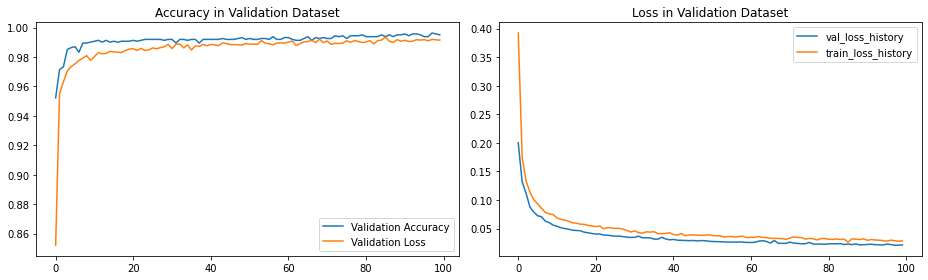


==== END ====
[[791   0]
 [  6 813]]

Sensitivity or recall total
0.9962732919254659

Sensitivity or recall per classes
[1.   0.99]

Precision
[0.99 1.  ]

F1 Score
[1. 1.]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.5058 Acc: 0.7993
val Loss: 0.2837 Acc: 0.9342

Epoch 1/99
----------
train Loss: 0.2253 Acc: 0.9532
val Loss: 0.1546 Acc: 0.9745

Epoch 2/99
----------
train Loss: 0.1491 Acc: 0.9710
val Loss: 0.1155 Acc: 0.9801

Epoch 3/99
----------
train Loss: 0.1173 Acc: 0.9781
val Loss: 0.0956 Acc: 0.9826

Epoch 4/99
----------
train Loss: 0.0997 Acc: 0.9817
val Loss: 0.0827 Acc: 0.9832

Epoch 5/99
----------
train Loss: 0.0876 Acc: 0.9826
val Loss: 0.0715 Acc: 0.9870

Epoch 6/99
----------
train Loss: 0.

val Loss: 0.0158 Acc: 0.9950

Epoch 92/99
----------
train Loss: 0.0141 Acc: 0.9961
val Loss: 0.0123 Acc: 0.9957

Epoch 93/99
----------
train Loss: 0.0132 Acc: 0.9972
val Loss: 0.0137 Acc: 0.9950

Epoch 94/99
----------
train Loss: 0.0140 Acc: 0.9961
val Loss: 0.0113 Acc: 0.9975

Epoch 95/99
----------
train Loss: 0.0140 Acc: 0.9964
val Loss: 0.0115 Acc: 0.9969

Epoch 96/99
----------
train Loss: 0.0136 Acc: 0.9967
val Loss: 0.0111 Acc: 0.9975

Epoch 97/99
----------
train Loss: 0.0138 Acc: 0.9961
val Loss: 0.0120 Acc: 0.9957

Epoch 98/99
----------
train Loss: 0.0135 Acc: 0.9970
val Loss: 0.0108 Acc: 0.9975

Epoch 99/99
----------
train Loss: 0.0129 Acc: 0.9970
val Loss: 0.0111 Acc: 0.9969


##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> ADAM
criteriun -> BCELoss

Training complete in 15m 38s
Best val Acc: 0.997516
##############################


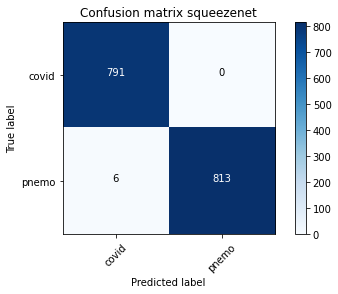

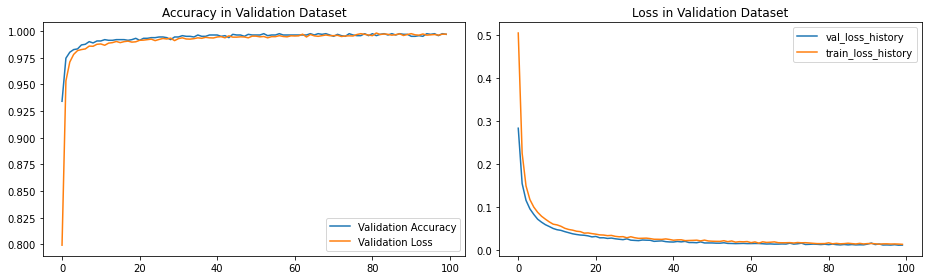


==== END ====
[[791   0]
 [  4 815]]

Sensitivity or recall total
0.9975155279503105

Sensitivity or recall per classes
[1. 1.]

Precision
[0.99 1.  ]

F1 Score
[1. 1.]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.4178 Acc: 0.8705
val Loss: 0.2380 Acc: 0.9553

Epoch 1/99
----------
train Loss: 0.2080 Acc: 0.9554
val Loss: 0.1596 Acc: 0.9640

Epoch 2/99
----------
train Loss: 0.1442 Acc: 0.9697
val Loss: 0.1116 Acc: 0.9789

Epoch 3/99
----------
train Loss: 0.1118 Acc: 0.9767
val Loss: 0.0931 Acc: 0.9807

Epoch 4/99
----------
train Loss: 0.0933 Acc: 0.9823
val Loss: 0.0761 Acc: 0.9851

Epoch 5/99
----------
train Loss: 0.0800 Acc: 0.9849
val Loss: 0.0685 Acc: 0.9839

Epoch 6/99
----------
train Loss: 0.0732

val Loss: 0.0114 Acc: 0.9969

Epoch 92/99
----------
train Loss: 0.0139 Acc: 0.9957
val Loss: 0.0125 Acc: 0.9963

Epoch 93/99
----------
train Loss: 0.0134 Acc: 0.9970
val Loss: 0.0110 Acc: 0.9975

Epoch 94/99
----------
train Loss: 0.0141 Acc: 0.9967
val Loss: 0.0109 Acc: 0.9975

Epoch 95/99
----------
train Loss: 0.0143 Acc: 0.9961
val Loss: 0.0110 Acc: 0.9975

Epoch 96/99
----------
train Loss: 0.0135 Acc: 0.9966
val Loss: 0.0106 Acc: 0.9975

Epoch 97/99
----------
train Loss: 0.0145 Acc: 0.9953
val Loss: 0.0108 Acc: 0.9975

Epoch 98/99
----------
train Loss: 0.0119 Acc: 0.9970
val Loss: 0.0119 Acc: 0.9963

Epoch 99/99
----------
train Loss: 0.0135 Acc: 0.9967
val Loss: 0.0126 Acc: 0.9963


##############################
------ Summary ------
model -> squeezenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> RMSprop
criteriun -> BCELoss

Training complete in 15m 37s
Best val Acc: 0.997516
##############################


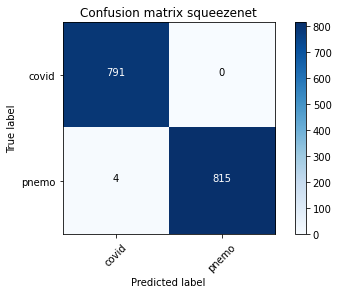

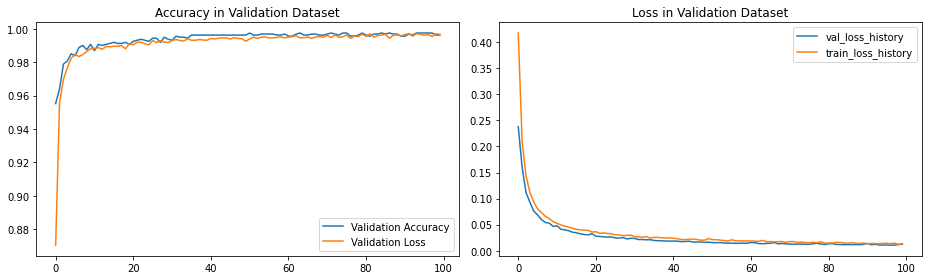


==== END ====
[[791   0]
 [  4 815]]

Sensitivity or recall total
0.9975155279503105

Sensitivity or recall per classes
[1. 1.]

Precision
[0.99 1.  ]

F1 Score
[1. 1.]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.3885 Acc: 0.8833
val Loss: 0.2057 Acc: 0.9789

Epoch 1/99
----------
train Loss: 0.1952 Acc: 0.9668
val Loss: 0.1306 Acc: 0.9876

Epoch 2/99
----------
train Loss: 0.1429 Acc: 0.9748
val Loss: 0.0994 Acc: 0.9907

Epoch 3/99
----------
train Loss: 0.1177 Acc: 0.9767
val Loss: 0.0806 Acc: 0.9907

Epoch 4/99
----------
train Loss: 0.1051 Acc: 0.9818
val Loss: 0.0727 Acc: 0.9925

Epoch 5/99
----------
train Loss: 0.1009 Acc: 0.9765
val Loss: 0.0625 Acc: 0.9925

Epoch 6/99
----------
train Loss: 0.0914 Acc: 

val Loss: 0.0120 Acc: 0.9981

Epoch 92/99
----------
train Loss: 0.0259 Acc: 0.9933
val Loss: 0.0135 Acc: 0.9975

Epoch 93/99
----------
train Loss: 0.0296 Acc: 0.9915
val Loss: 0.0116 Acc: 0.9969

Epoch 94/99
----------
train Loss: 0.0299 Acc: 0.9910
val Loss: 0.0110 Acc: 0.9969

Epoch 95/99
----------
train Loss: 0.0293 Acc: 0.9904
val Loss: 0.0099 Acc: 0.9975

Epoch 96/99
----------
train Loss: 0.0248 Acc: 0.9936
val Loss: 0.0101 Acc: 0.9981

Epoch 97/99
----------
train Loss: 0.0333 Acc: 0.9896
val Loss: 0.0121 Acc: 0.9969

Epoch 98/99
----------
train Loss: 0.0292 Acc: 0.9908
val Loss: 0.0134 Acc: 0.9963

Epoch 99/99
----------
train Loss: 0.0274 Acc: 0.9933
val Loss: 0.0170 Acc: 0.9957


##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> SGD
criteriun -> BCELoss

Training complete in 40m 3s
Best val Acc: 0.998758
##############################


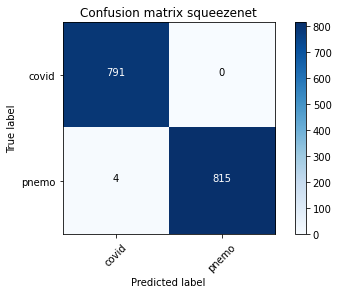

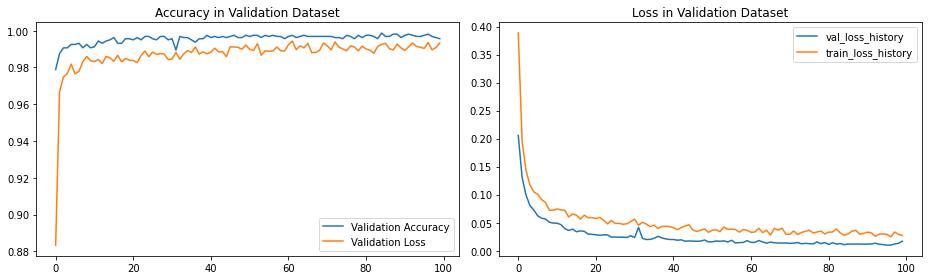


==== END ====
[[790   1]
 [  1 818]]

Sensitivity or recall total
0.9987577639751553

Sensitivity or recall per classes
[1. 1.]

Precision
[1. 1.]

F1 Score
[1. 1.]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.4493 Acc: 0.8565
val Loss: 0.2558 Acc: 0.9839

Epoch 1/99
----------
train Loss: 0.2312 Acc: 0.9629
val Loss: 0.1596 Acc: 0.9814

Epoch 2/99
----------
train Loss: 0.1698 Acc: 0.9680
val Loss: 0.1177 Acc: 0.9863

Epoch 3/99
----------
train Loss: 0.1390 Acc: 0.9744
val Loss: 0.0888 Acc: 0.9925

Epoch 4/99
----------
train Loss: 0.1136 Acc: 0.9783
val Loss: 0.0756 Acc: 0.9901

Epoch 5/99
----------
train Loss: 0.1028 Acc: 0.9787
val Loss: 0.0658 Acc: 0.9925

Epoch 6/99
----------
train Loss: 0.0907 Acc: 0.98

val Loss: 0.0072 Acc: 0.9988

Epoch 92/99
----------
train Loss: 0.0200 Acc: 0.9939
val Loss: 0.0068 Acc: 0.9975

Epoch 93/99
----------
train Loss: 0.0209 Acc: 0.9943
val Loss: 0.0075 Acc: 0.9981

Epoch 94/99
----------
train Loss: 0.0194 Acc: 0.9936
val Loss: 0.0056 Acc: 0.9988

Epoch 95/99
----------
train Loss: 0.0209 Acc: 0.9938
val Loss: 0.0083 Acc: 0.9975

Epoch 96/99
----------
train Loss: 0.0248 Acc: 0.9924
val Loss: 0.0055 Acc: 0.9981

Epoch 97/99
----------
train Loss: 0.0231 Acc: 0.9924
val Loss: 0.0056 Acc: 0.9994

Epoch 98/99
----------
train Loss: 0.0194 Acc: 0.9941
val Loss: 0.0075 Acc: 0.9975

Epoch 99/99
----------
train Loss: 0.0227 Acc: 0.9924
val Loss: 0.0059 Acc: 0.9975


##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> ADAM
criteriun -> BCELoss

Training complete in 40m 11s
Best val Acc: 0.999379
##############################


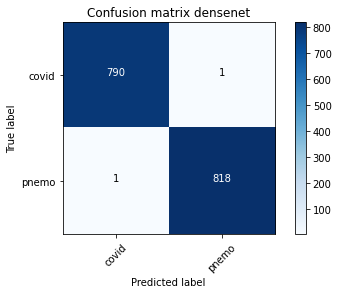

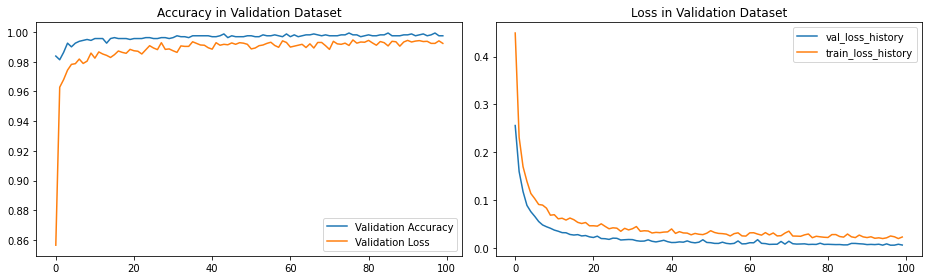


==== END ====
[[791   0]
 [  1 818]]

Sensitivity or recall total
0.9993788819875776

Sensitivity or recall per classes
[1. 1.]

Precision
[1. 1.]

F1 Score
[1. 1.]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> densenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 classifier.weight
	 classifier.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.3342 Acc: 0.9321
val Loss: 0.1991 Acc: 0.9851

Epoch 1/99
----------
train Loss: 0.1891 Acc: 0.9683
val Loss: 0.1329 Acc: 0.9832

Epoch 2/99
----------
train Loss: 0.1443 Acc: 0.9717
val Loss: 0.0939 Acc: 0.9894

Epoch 3/99
----------
train Loss: 0.1177 Acc: 0.9750
val Loss: 0.0760 Acc: 0.9894

Epoch 4/99
----------
train Loss: 0.0964 Acc: 0.9803
val Loss: 0.0675 Acc: 0.9894

Epoch 5/99
----------
train Loss: 0.0916 Acc: 0.9790
val Loss: 0.0557 Acc: 0.9913

Epoch 6/99
----------
train Loss: 0.0867 Acc: 0.97

val Loss: 0.0055 Acc: 0.9994

Epoch 92/99
----------
train Loss: 0.0242 Acc: 0.9932
val Loss: 0.0076 Acc: 0.9975

Epoch 93/99
----------
train Loss: 0.0212 Acc: 0.9935
val Loss: 0.0052 Acc: 0.9988

Epoch 94/99
----------
train Loss: 0.0225 Acc: 0.9938
val Loss: 0.0064 Acc: 0.9988

Epoch 95/99
----------
train Loss: 0.0210 Acc: 0.9929
val Loss: 0.0051 Acc: 0.9988

Epoch 96/99
----------
train Loss: 0.0188 Acc: 0.9943
val Loss: 0.0059 Acc: 0.9975

Epoch 97/99
----------
train Loss: 0.0209 Acc: 0.9922
val Loss: 0.0055 Acc: 0.9988

Epoch 98/99
----------
train Loss: 0.0239 Acc: 0.9922
val Loss: 0.0060 Acc: 0.9994

Epoch 99/99
----------
train Loss: 0.0199 Acc: 0.9943
val Loss: 0.0067 Acc: 0.9981


##############################
------ Summary ------
model -> densenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> RMSprop
criteriun -> BCELoss

Training complete in 40m 16s
Best val Acc: 0.999379
##############################


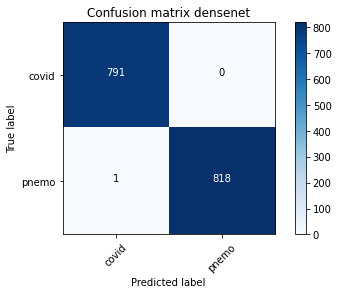

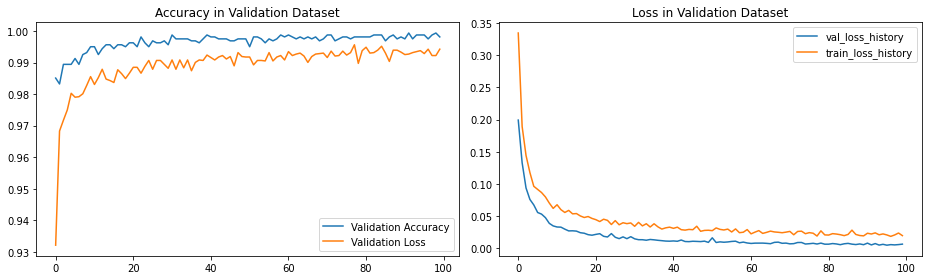


==== END ====
[[791   0]
 [  1 818]]

Sensitivity or recall total
0.9993788819875776

Sensitivity or recall per classes
[1. 1.]

Precision
[1. 1.]

F1 Score
[1. 1.]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> resnet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.4056 Acc: 0.8532
val Loss: 0.2356 Acc: 0.9621

Epoch 1/99
----------
train Loss: 0.2148 Acc: 0.9515
val Loss: 0.1541 Acc: 0.9814

Epoch 2/99
----------
train Loss: 0.1679 Acc: 0.9605
val Loss: 0.1184 Acc: 0.9851

Epoch 3/99
----------
train Loss: 0.1375 Acc: 0.9696
val Loss: 0.0987 Acc: 0.9870

Epoch 4/99
----------
train Loss: 0.1264 Acc: 0.9706
val Loss: 0.0947 Acc: 0.9901

Epoch 5/99
----------
train Loss: 0.1111 Acc: 0.9750
val Loss: 0.0758 Acc: 0.9907

Epoch 6/99
----------
train Loss: 0.1092 Acc: 0.9731
val Loss: 0.079

train Loss: 0.0400 Acc: 0.9871
val Loss: 0.0186 Acc: 0.9975

Epoch 93/99
----------
train Loss: 0.0422 Acc: 0.9868
val Loss: 0.0184 Acc: 0.9981

Epoch 94/99
----------
train Loss: 0.0387 Acc: 0.9885
val Loss: 0.0188 Acc: 0.9975

Epoch 95/99
----------
train Loss: 0.0376 Acc: 0.9885
val Loss: 0.0154 Acc: 0.9981

Epoch 96/99
----------
train Loss: 0.0369 Acc: 0.9891
val Loss: 0.0206 Acc: 0.9969

Epoch 97/99
----------
train Loss: 0.0392 Acc: 0.9866
val Loss: 0.0189 Acc: 0.9969

Epoch 98/99
----------
train Loss: 0.0411 Acc: 0.9874
val Loss: 0.0168 Acc: 0.9975

Epoch 99/99
----------
train Loss: 0.0382 Acc: 0.9882
val Loss: 0.0160 Acc: 0.9981


##############################
------ Summary ------
model -> resnet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> SGD
criteriun -> BCELoss

Training complete in 15m 31s
Best val Acc: 0.998758
##############################


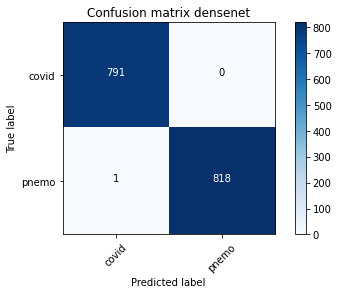

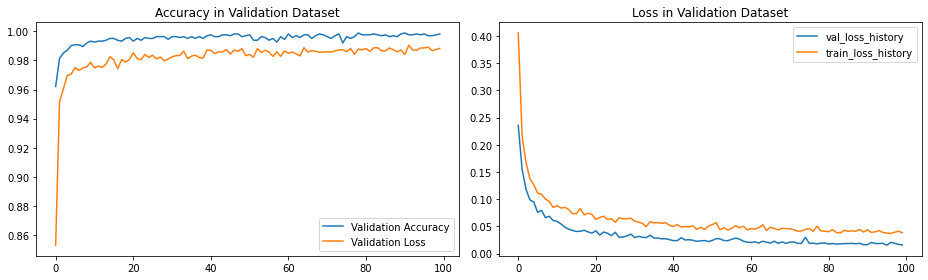


==== END ====
[[791   0]
 [  2 817]]

Sensitivity or recall total
0.9987577639751553

Sensitivity or recall per classes
[1. 1.]

Precision
[1. 1.]

F1 Score
[1. 1.]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> resnet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.4255 Acc: 0.8576
val Loss: 0.2800 Acc: 0.9609

Epoch 1/99
----------
train Loss: 0.2431 Acc: 0.9500
val Loss: 0.1843 Acc: 0.9776

Epoch 2/99
----------
train Loss: 0.1806 Acc: 0.9635
val Loss: 0.1329 Acc: 0.9832

Epoch 3/99
----------
train Loss: 0.1497 Acc: 0.9660
val Loss: 0.1128 Acc: 0.9814

Epoch 4/99
----------
train Loss: 0.1317 Acc: 0.9685
val Loss: 0.0932 Acc: 0.9863

Epoch 5/99
----------
train Loss: 0.1251 Acc: 0.9696
val Loss: 0.0900 Acc: 0.9851

Epoch 6/99
----------
train Loss: 0.1030 Acc: 0.9750
val Loss: 0.079

train Loss: 0.0326 Acc: 0.9887
val Loss: 0.0132 Acc: 0.9988

Epoch 93/99
----------
train Loss: 0.0368 Acc: 0.9873
val Loss: 0.0121 Acc: 0.9975

Epoch 94/99
----------
train Loss: 0.0319 Acc: 0.9890
val Loss: 0.0127 Acc: 0.9988

Epoch 95/99
----------
train Loss: 0.0307 Acc: 0.9902
val Loss: 0.0136 Acc: 0.9981

Epoch 96/99
----------
train Loss: 0.0376 Acc: 0.9863
val Loss: 0.0138 Acc: 0.9963

Epoch 97/99
----------
train Loss: 0.0363 Acc: 0.9879
val Loss: 0.0151 Acc: 0.9963

Epoch 98/99
----------
train Loss: 0.0339 Acc: 0.9882
val Loss: 0.0122 Acc: 0.9975

Epoch 99/99
----------
train Loss: 0.0309 Acc: 0.9891
val Loss: 0.0170 Acc: 0.9957


##############################
------ Summary ------
model -> resnet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> ADAM
criteriun -> BCELoss

Training complete in 15m 29s
Best val Acc: 0.998758
##############################


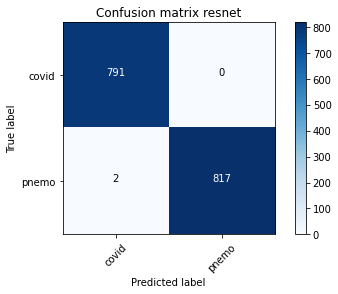

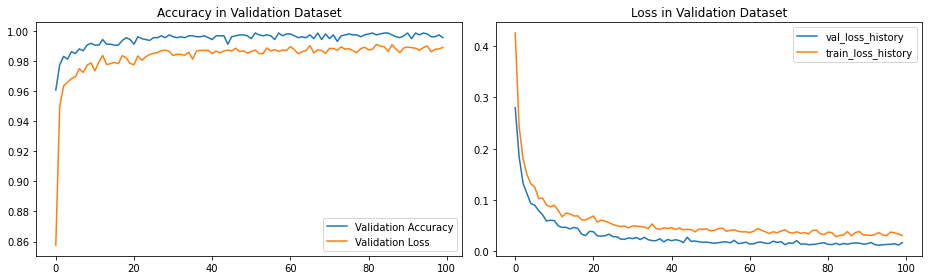


==== END ====
[[791   0]
 [  2 817]]

Sensitivity or recall total
0.9987577639751553

Sensitivity or recall per classes
[1. 1.]

Precision
[1. 1.]

F1 Score
[1. 1.]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> resnet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.3785 Acc: 0.8928
val Loss: 0.2462 Acc: 0.9516

Epoch 1/99
----------
train Loss: 0.2170 Acc: 0.9548
val Loss: 0.1604 Acc: 0.9733

Epoch 2/99
----------
train Loss: 0.1673 Acc: 0.9629
val Loss: 0.1249 Acc: 0.9764

Epoch 3/99
----------
train Loss: 0.1386 Acc: 0.9657
val Loss: 0.0986 Acc: 0.9832

Epoch 4/99
----------
train Loss: 0.1237 Acc: 0.9686
val Loss: 0.0869 Acc: 0.9857

Epoch 5/99
----------
train Loss: 0.1146 Acc: 0.9694
val Loss: 0.0768 Acc: 0.9894

Epoch 6/99
----------
train Loss: 0.1031 Acc: 0.9725
val Loss: 0.075

train Loss: 0.0328 Acc: 0.9882
val Loss: 0.0133 Acc: 0.9975

Epoch 93/99
----------
train Loss: 0.0351 Acc: 0.9884
val Loss: 0.0136 Acc: 0.9969

Epoch 94/99
----------
train Loss: 0.0317 Acc: 0.9885
val Loss: 0.0126 Acc: 0.9975

Epoch 95/99
----------
train Loss: 0.0332 Acc: 0.9891
val Loss: 0.0169 Acc: 0.9963

Epoch 96/99
----------
train Loss: 0.0344 Acc: 0.9879
val Loss: 0.0125 Acc: 0.9975

Epoch 97/99
----------
train Loss: 0.0318 Acc: 0.9891
val Loss: 0.0127 Acc: 0.9975

Epoch 98/99
----------
train Loss: 0.0335 Acc: 0.9884
val Loss: 0.0135 Acc: 0.9975

Epoch 99/99
----------
train Loss: 0.0317 Acc: 0.9888
val Loss: 0.0162 Acc: 0.9957


##############################
------ Summary ------
model -> resnet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> RMSprop
criteriun -> BCELoss

Training complete in 15m 30s
Best val Acc: 0.998758
##############################


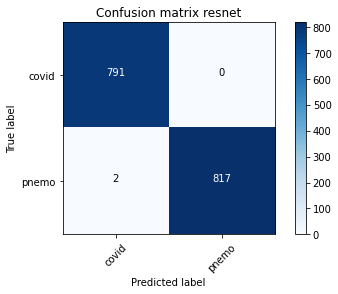

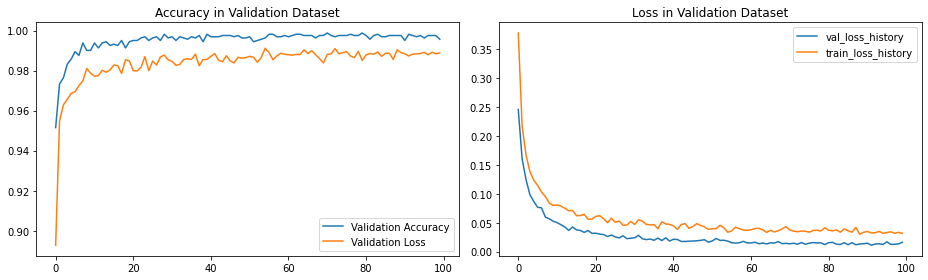


==== END ====
[[791   0]
 [  2 817]]

Sensitivity or recall total
0.9987577639751553

Sensitivity or recall per classes
[1. 1.]

Precision
[1. 1.]

F1 Score
[1. 1.]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> alexnet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.6.weight
	 classifier.6.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.2604 Acc: 0.8983
val Loss: 0.1362 Acc: 0.9627

Epoch 1/99
----------
train Loss: 0.1693 Acc: 0.9391
val Loss: 0.1208 Acc: 0.9609

Epoch 2/99
----------
train Loss: 0.1465 Acc: 0.9464
val Loss: 0.0967 Acc: 0.9696

Epoch 3/99
----------
train Loss: 0.1373 Acc: 0.9500
val Loss: 0.0957 Acc: 0.9696

Epoch 4/99
----------
train Loss: 0.1348 Acc: 0.9492
val Loss: 0.0907 Acc: 0.9708

Epoch 5/99
----------
train Loss: 0.1339 Acc: 0.9498
val Loss: 0.0811 Acc: 0.9770

Epoch 6/99
----------
train Loss: 0.1263 Acc: 0

val Loss: 0.0588 Acc: 0.9776

Epoch 92/99
----------
train Loss: 0.0902 Acc: 0.9678
val Loss: 0.0561 Acc: 0.9814

Epoch 93/99
----------
train Loss: 0.0888 Acc: 0.9685
val Loss: 0.0527 Acc: 0.9814

Epoch 94/99
----------
train Loss: 0.0868 Acc: 0.9705
val Loss: 0.0526 Acc: 0.9814

Epoch 95/99
----------
train Loss: 0.0905 Acc: 0.9671
val Loss: 0.0506 Acc: 0.9826

Epoch 96/99
----------
train Loss: 0.0898 Acc: 0.9696
val Loss: 0.0483 Acc: 0.9863

Epoch 97/99
----------
train Loss: 0.0884 Acc: 0.9672
val Loss: 0.0443 Acc: 0.9882

Epoch 98/99
----------
train Loss: 0.0869 Acc: 0.9686
val Loss: 0.0533 Acc: 0.9814

Epoch 99/99
----------
train Loss: 0.0870 Acc: 0.9705
val Loss: 0.0528 Acc: 0.9820


##############################
------ Summary ------
model -> alexnet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> SGD
criteriun -> BCELoss

Training complete in 10m 59s
Best val Acc: 0.990683
##############################


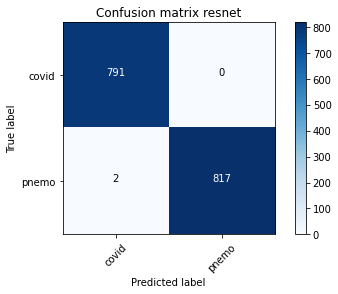

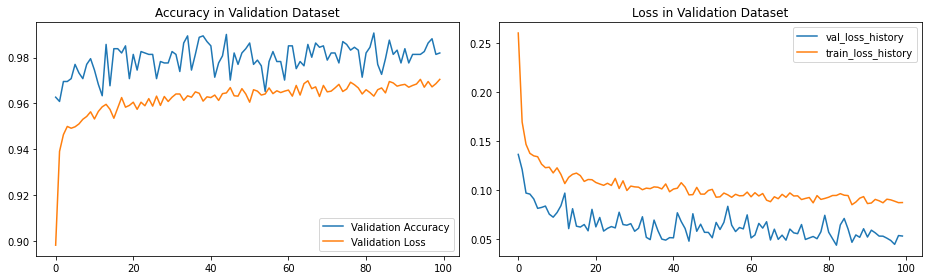


==== END ====
[[784   7]
 [  8 811]]

Sensitivity or recall total
0.9906832298136646

Sensitivity or recall per classes
[0.99 0.99]

Precision
[0.99 0.99]

F1 Score
[0.99 0.99]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> alexnet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.6.weight
	 classifier.6.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.3044 Acc: 0.8942
val Loss: 0.1844 Acc: 0.9416

Epoch 1/99
----------
train Loss: 0.1707 Acc: 0.9436
val Loss: 0.1289 Acc: 0.9584

Epoch 2/99
----------
train Loss: 0.1475 Acc: 0.9477
val Loss: 0.1200 Acc: 0.9602

Epoch 3/99
----------
train Loss: 0.1369 Acc: 0.9518
val Loss: 0.1134 Acc: 0.9578

Epoch 4/99
----------
train Loss: 0.1250 Acc: 0.9551
val Loss: 0.0896 Acc: 0.9714

Epoch 5/99
----------
train Loss: 0.1180 Acc: 0.9574
val Loss: 0.0875 Acc: 0.9733

Epoch 6/99
----------
train Loss: 0

val Loss: 0.0491 Acc: 0.9826

Epoch 92/99
----------
train Loss: 0.0777 Acc: 0.9730
val Loss: 0.0573 Acc: 0.9758

Epoch 93/99
----------
train Loss: 0.0748 Acc: 0.9714
val Loss: 0.0504 Acc: 0.9807

Epoch 94/99
----------
train Loss: 0.0768 Acc: 0.9724
val Loss: 0.0491 Acc: 0.9807

Epoch 95/99
----------
train Loss: 0.0815 Acc: 0.9713
val Loss: 0.0441 Acc: 0.9863

Epoch 96/99
----------
train Loss: 0.0780 Acc: 0.9714
val Loss: 0.0623 Acc: 0.9720

Epoch 97/99
----------
train Loss: 0.0718 Acc: 0.9722
val Loss: 0.0418 Acc: 0.9857

Epoch 98/99
----------
train Loss: 0.0771 Acc: 0.9739
val Loss: 0.0413 Acc: 0.9882

Epoch 99/99
----------
train Loss: 0.0753 Acc: 0.9739
val Loss: 0.0607 Acc: 0.9745


##############################
------ Summary ------
model -> alexnet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> ADAM
criteriun -> BCELoss

Training complete in 10m 54s
Best val Acc: 0.990062
##############################


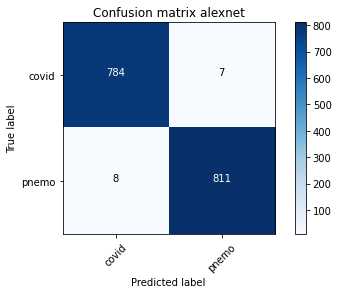

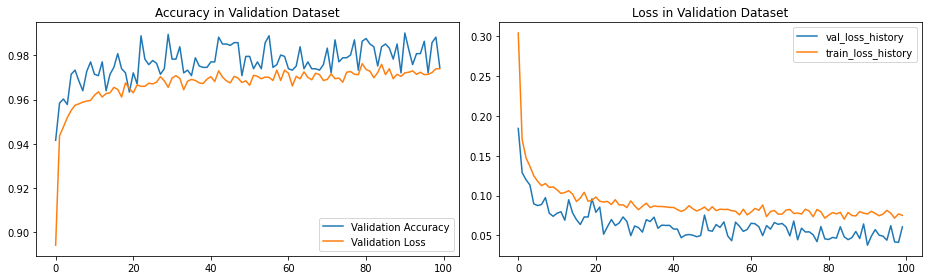


==== END ====
[[781  10]
 [  6 813]]

Sensitivity or recall total
0.9900621118012423

Sensitivity or recall per classes
[0.99 0.99]

Precision
[0.99 0.99]

F1 Score
[0.99 0.99]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> alexnet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 classifier.6.weight
	 classifier.6.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.2427 Acc: 0.9177
val Loss: 0.1440 Acc: 0.9602

Epoch 1/99
----------
train Loss: 0.1572 Acc: 0.9461
val Loss: 0.1098 Acc: 0.9733

Epoch 2/99
----------
train Loss: 0.1379 Acc: 0.9503
val Loss: 0.0939 Acc: 0.9758

Epoch 3/99
----------
train Loss: 0.1281 Acc: 0.9550
val Loss: 0.1143 Acc: 0.9565

Epoch 4/99
----------
train Loss: 0.1220 Acc: 0.9571
val Loss: 0.1045 Acc: 0.9609

Epoch 5/99
----------
train Loss: 0.1154 Acc: 0.9613
val Loss: 0.0921 Acc: 0.9677

Epoch 6/99
----------
train Loss: 0

val Loss: 0.0643 Acc: 0.9752

Epoch 92/99
----------
train Loss: 0.0724 Acc: 0.9728
val Loss: 0.0575 Acc: 0.9776

Epoch 93/99
----------
train Loss: 0.0726 Acc: 0.9742
val Loss: 0.0549 Acc: 0.9789

Epoch 94/99
----------
train Loss: 0.0817 Acc: 0.9713
val Loss: 0.0456 Acc: 0.9870

Epoch 95/99
----------
train Loss: 0.0739 Acc: 0.9727
val Loss: 0.0546 Acc: 0.9789

Epoch 96/99
----------
train Loss: 0.0790 Acc: 0.9730
val Loss: 0.0564 Acc: 0.9789

Epoch 97/99
----------
train Loss: 0.0783 Acc: 0.9713
val Loss: 0.0485 Acc: 0.9832

Epoch 98/99
----------
train Loss: 0.0792 Acc: 0.9714
val Loss: 0.0476 Acc: 0.9832

Epoch 99/99
----------
train Loss: 0.0774 Acc: 0.9720
val Loss: 0.0532 Acc: 0.9807


##############################
------ Summary ------
model -> alexnet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> RMSprop
criteriun -> BCELoss

Training complete in 10m 53s
Best val Acc: 0.988199
##############################


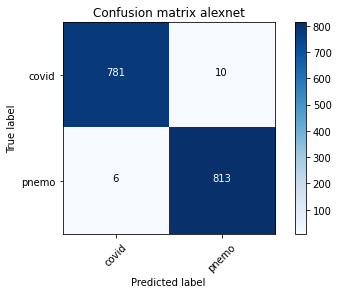

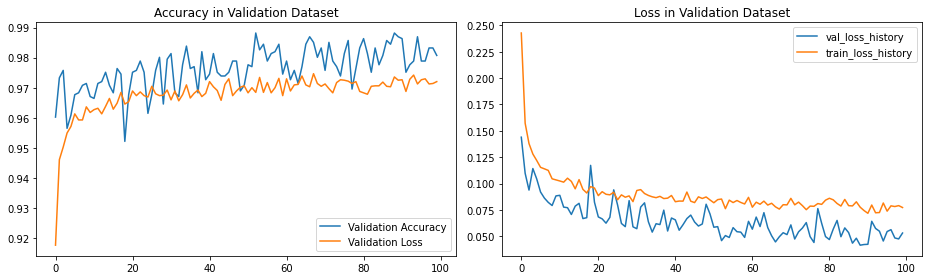


==== END ====
[[777  14]
 [  5 814]]

Sensitivity or recall total
0.9881987577639751

Sensitivity or recall per classes
[0.98 0.99]

Precision
[0.99 0.98]

F1 Score
[0.99 0.99]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> vgg
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.6.weight
	 classifier.6.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.3131 Acc: 0.9172
val Loss: 0.1455 Acc: 0.9851

Epoch 1/99
----------
train Loss: 0.1509 Acc: 0.9705
val Loss: 0.1002 Acc: 0.9876

Epoch 2/99
----------
train Loss: 0.1213 Acc: 0.9739
val Loss: 0.0817 Acc: 0.9845

Epoch 3/99
----------
train Loss: 0.1030 Acc: 0.9765
val Loss: 0.0668 Acc: 0.9888

Epoch 4/99
----------
train Loss: 0.0972 Acc: 0.9751
val Loss: 0.0577 Acc: 0.9876

Epoch 5/99
----------
train Loss: 0.0849 Acc: 0.9779
val Loss: 0.0533 Acc: 0.9888

Epoch 6/99
----------
train Loss: 0.078

val Loss: 0.0128 Acc: 0.9969

Epoch 92/99
----------
train Loss: 0.0409 Acc: 0.9859
val Loss: 0.0166 Acc: 0.9932

Epoch 93/99
----------
train Loss: 0.0380 Acc: 0.9885
val Loss: 0.0139 Acc: 0.9944

Epoch 94/99
----------
train Loss: 0.0385 Acc: 0.9865
val Loss: 0.0125 Acc: 0.9969

Epoch 95/99
----------
train Loss: 0.0384 Acc: 0.9882
val Loss: 0.0121 Acc: 0.9963

Epoch 96/99
----------
train Loss: 0.0373 Acc: 0.9894
val Loss: 0.0127 Acc: 0.9969

Epoch 97/99
----------
train Loss: 0.0368 Acc: 0.9896
val Loss: 0.0120 Acc: 0.9969

Epoch 98/99
----------
train Loss: 0.0363 Acc: 0.9894
val Loss: 0.0131 Acc: 0.9957

Epoch 99/99
----------
train Loss: 0.0401 Acc: 0.9870
val Loss: 0.0141 Acc: 0.9944


##############################
------ Summary ------
model -> vgg
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> SGD
criteriun -> BCELoss

Training complete in 37m 16s
Best val Acc: 0.997516
##############################


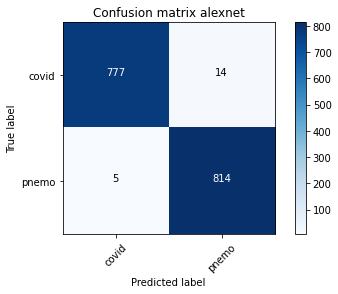

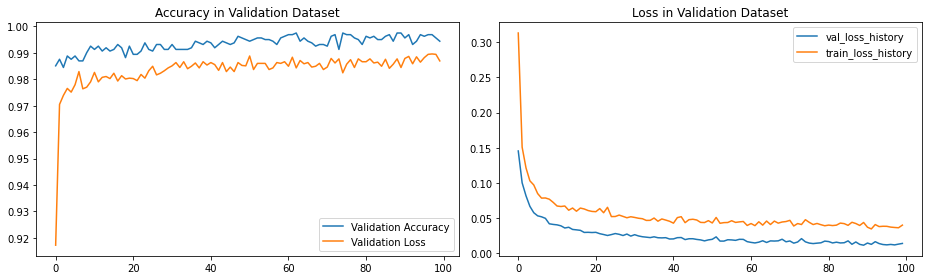


==== END ====
[[789   2]
 [  2 817]]

Sensitivity or recall total
0.9975155279503105

Sensitivity or recall per classes
[1. 1.]

Precision
[1. 1.]

F1 Score
[1. 1.]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> vgg
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.6.weight
	 classifier.6.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.2393 Acc: 0.9464
val Loss: 0.0915 Acc: 0.9851

Epoch 1/99
----------
train Loss: 0.1033 Acc: 0.9741
val Loss: 0.0618 Acc: 0.9888

Epoch 2/99
----------
train Loss: 0.0762 Acc: 0.9793
val Loss: 0.0455 Acc: 0.9919

Epoch 3/99
----------
train Loss: 0.0641 Acc: 0.9832
val Loss: 0.0374 Acc: 0.9919

Epoch 4/99
----------
train Loss: 0.0689 Acc: 0.9775
val Loss: 0.0293 Acc: 0.9938

Epoch 5/99
----------
train Loss: 0.0594 Acc: 0.9826
val Loss: 0.0258 Acc: 0.9932

Epoch 6/99
----------
train Loss: 0.0529 Acc: 0.984

val Loss: 0.0042 Acc: 0.9994

Epoch 92/99
----------
train Loss: 0.0270 Acc: 0.9907
val Loss: 0.0042 Acc: 0.9988

Epoch 93/99
----------
train Loss: 0.0213 Acc: 0.9924
val Loss: 0.0033 Acc: 0.9994

Epoch 94/99
----------
train Loss: 0.0278 Acc: 0.9902
val Loss: 0.0028 Acc: 1.0000

Epoch 95/99
----------
train Loss: 0.0255 Acc: 0.9911
val Loss: 0.0062 Acc: 0.9981

Epoch 96/99
----------
train Loss: 0.0308 Acc: 0.9893
val Loss: 0.0030 Acc: 0.9994

Epoch 97/99
----------
train Loss: 0.0244 Acc: 0.9916
val Loss: 0.0034 Acc: 0.9994

Epoch 98/99
----------
train Loss: 0.0229 Acc: 0.9924
val Loss: 0.0041 Acc: 0.9988

Epoch 99/99
----------
train Loss: 0.0310 Acc: 0.9884
val Loss: 0.0049 Acc: 0.9981


##############################
------ Summary ------
model -> vgg
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> ADAM
criteriun -> BCELoss

Training complete in 37m 28s
Best val Acc: 1.000000
##############################


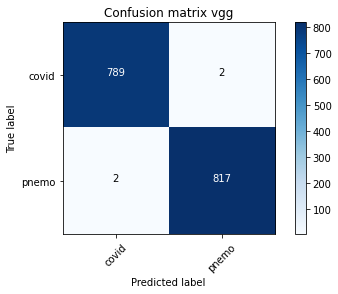

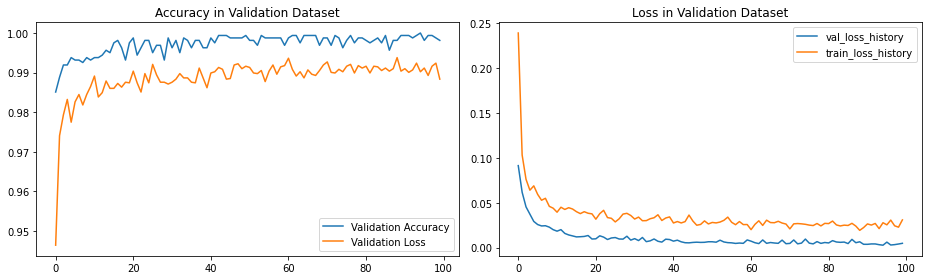


==== END ====
[[791   0]
 [  0 819]]

Sensitivity or recall total
1.0

Sensitivity or recall per classes
[1. 1.]

Precision
[1. 1.]

F1 Score
[1. 1.]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> vgg
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 classifier.6.weight
	 classifier.6.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.1640 Acc: 0.9637
val Loss: 0.0713 Acc: 0.9876

Epoch 1/99
----------
train Loss: 0.0853 Acc: 0.9779
val Loss: 0.0467 Acc: 0.9913

Epoch 2/99
----------
train Loss: 0.0695 Acc: 0.9795
val Loss: 0.0356 Acc: 0.9919

Epoch 3/99
----------
train Loss: 0.0640 Acc: 0.9790
val Loss: 0.0303 Acc: 0.9925

Epoch 4/99
----------
train Loss: 0.0547 Acc: 0.9826
val Loss: 0.0234 Acc: 0.9944

Epoch 5/99
----------
train Loss: 0.0520 Acc: 0.9817
val Loss: 0.0219 Acc: 0.9938

Epoch 6/99
----------
train Loss: 0.0475 Acc: 0.9854
val Loss: 0.0

train Loss: 0.0320 Acc: 0.9891
val Loss: 0.0037 Acc: 0.9988

Epoch 93/99
----------
train Loss: 0.0269 Acc: 0.9916
val Loss: 0.0055 Acc: 0.9981

Epoch 94/99
----------
train Loss: 0.0275 Acc: 0.9888
val Loss: 0.0043 Acc: 0.9988

Epoch 95/99
----------
train Loss: 0.0299 Acc: 0.9879
val Loss: 0.0048 Acc: 0.9988

Epoch 96/99
----------
train Loss: 0.0261 Acc: 0.9911
val Loss: 0.0060 Acc: 0.9975

Epoch 97/99
----------
train Loss: 0.0242 Acc: 0.9907
val Loss: 0.0039 Acc: 0.9994

Epoch 98/99
----------
train Loss: 0.0215 Acc: 0.9918
val Loss: 0.0070 Acc: 0.9975

Epoch 99/99
----------
train Loss: 0.0279 Acc: 0.9896
val Loss: 0.0035 Acc: 0.9994


##############################
------ Summary ------
model -> vgg
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> RMSprop
criteriun -> BCELoss

Training complete in 37m 31s
Best val Acc: 1.000000
##############################


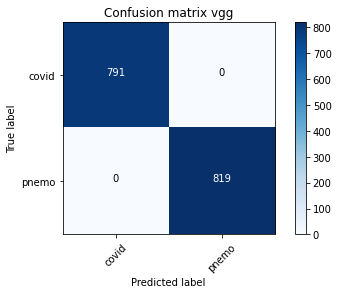

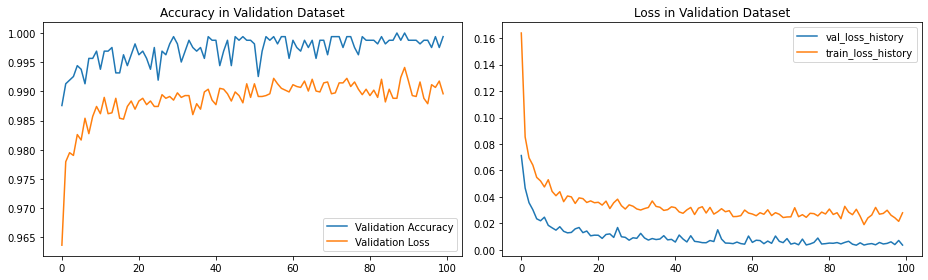


==== END ====
[[791   0]
 [  0 819]]

Sensitivity or recall total
1.0

Sensitivity or recall per classes
[1. 1.]

Precision
[1. 1.]

F1 Score
[1. 1.]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> googlenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.5383 Acc: 0.8217
val Loss: 0.4019 Acc: 0.9658

Epoch 1/99
----------
train Loss: 0.3669 Acc: 0.9385
val Loss: 0.2853 Acc: 0.9739

Epoch 2/99
----------
train Loss: 0.2893 Acc: 0.9520
val Loss: 0.2262 Acc: 0.9820

Epoch 3/99
----------
train Loss: 0.2460 Acc: 0.9587
val Loss: 0.1996 Acc: 0.9851

Epoch 4/99
----------
train Loss: 0.2173 Acc: 0.9591
val Loss: 0.1679 Acc: 0.9851

Epoch 5/99
----------
train Loss: 0.2015 Acc: 0.9604
val Loss: 0.1573 Acc: 0.9845

Epoch 6/99
----------
train Loss: 0.1871 Acc: 0.9654
val Loss: 0.1420 Acc: 0.985

train Loss: 0.0691 Acc: 0.9787
val Loss: 0.0351 Acc: 0.9919

Epoch 93/99
----------
train Loss: 0.0692 Acc: 0.9793
val Loss: 0.0411 Acc: 0.9932

Epoch 94/99
----------
train Loss: 0.0724 Acc: 0.9784
val Loss: 0.0365 Acc: 0.9913

Epoch 95/99
----------
train Loss: 0.0682 Acc: 0.9784
val Loss: 0.0321 Acc: 0.9932

Epoch 96/99
----------
train Loss: 0.0751 Acc: 0.9731
val Loss: 0.0332 Acc: 0.9938

Epoch 97/99
----------
train Loss: 0.0686 Acc: 0.9786
val Loss: 0.0329 Acc: 0.9932

Epoch 98/99
----------
train Loss: 0.0674 Acc: 0.9797
val Loss: 0.0352 Acc: 0.9932

Epoch 99/99
----------
train Loss: 0.0732 Acc: 0.9750
val Loss: 0.0344 Acc: 0.9925


##############################
------ Summary ------
model -> googlenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> SGD
criteriun -> BCELoss

Training complete in 18m 29s
Best val Acc: 0.994410
##############################


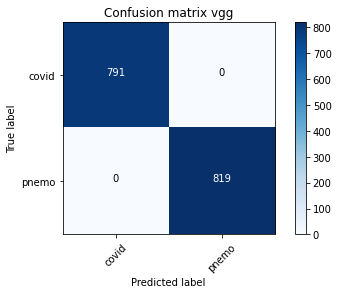

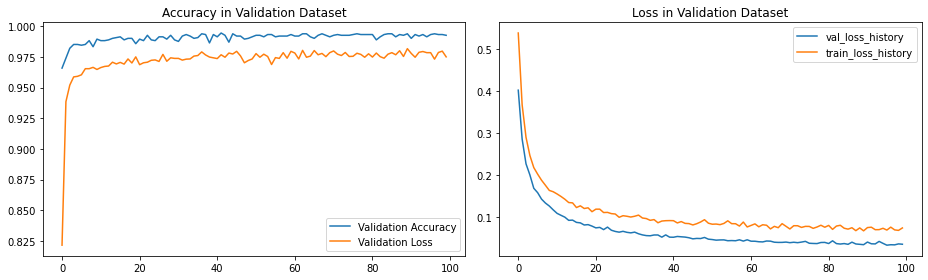


==== END ====
[[790   1]
 [  8 811]]

Sensitivity or recall total
0.9944099378881988

Sensitivity or recall per classes
[1.   0.99]

Precision
[0.99 1.  ]

F1 Score
[0.99 0.99]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> googlenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.5084 Acc: 0.8405
val Loss: 0.3450 Acc: 0.9708

Epoch 1/99
----------
train Loss: 0.3043 Acc: 0.9532
val Loss: 0.2325 Acc: 0.9733

Epoch 2/99
----------
train Loss: 0.2301 Acc: 0.9604
val Loss: 0.1715 Acc: 0.9863

Epoch 3/99
----------
train Loss: 0.1947 Acc: 0.9581
val Loss: 0.1399 Acc: 0.9882

Epoch 4/99
----------
train Loss: 0.1621 Acc: 0.9655
val Loss: 0.1231 Acc: 0.9832

Epoch 5/99
----------
train Loss: 0.1455 Acc: 0.9692
val Loss: 0.1096 Acc: 0.9814

Epoch 6/99
----------
train Loss: 0.1340 Acc: 0.9697


val Loss: 0.0183 Acc: 0.9957

Epoch 92/99
----------
train Loss: 0.0550 Acc: 0.9812
val Loss: 0.0179 Acc: 0.9944

Epoch 93/99
----------
train Loss: 0.0525 Acc: 0.9797
val Loss: 0.0200 Acc: 0.9944

Epoch 94/99
----------
train Loss: 0.0611 Acc: 0.9786
val Loss: 0.0191 Acc: 0.9950

Epoch 95/99
----------
train Loss: 0.0538 Acc: 0.9817
val Loss: 0.0206 Acc: 0.9944

Epoch 96/99
----------
train Loss: 0.0485 Acc: 0.9842
val Loss: 0.0196 Acc: 0.9944

Epoch 97/99
----------
train Loss: 0.0518 Acc: 0.9812
val Loss: 0.0176 Acc: 0.9957

Epoch 98/99
----------
train Loss: 0.0523 Acc: 0.9826
val Loss: 0.0209 Acc: 0.9944

Epoch 99/99
----------
train Loss: 0.0497 Acc: 0.9806
val Loss: 0.0164 Acc: 0.9963


##############################
------ Summary ------
model -> googlenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> ADAM
criteriun -> BCELoss

Training complete in 18m 30s
Best val Acc: 0.996273
##############################


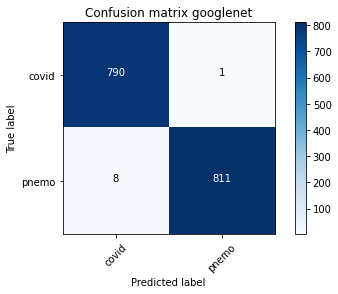

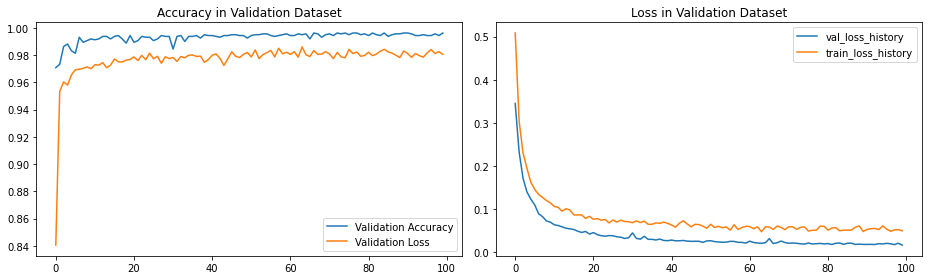


==== END ====
[[790   1]
 [  5 814]]

Sensitivity or recall total
0.9962732919254659

Sensitivity or recall per classes
[1.   0.99]

Precision
[0.99 1.  ]

F1 Score
[1. 1.]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> googlenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.4307 Acc: 0.8840
val Loss: 0.2871 Acc: 0.9733

Epoch 1/99
----------
train Loss: 0.2729 Acc: 0.9478
val Loss: 0.1937 Acc: 0.9807

Epoch 2/99
----------
train Loss: 0.2065 Acc: 0.9579
val Loss: 0.1479 Acc: 0.9857

Epoch 3/99
----------
train Loss: 0.1820 Acc: 0.9574
val Loss: 0.1257 Acc: 0.9857

Epoch 4/99
----------
train Loss: 0.1535 Acc: 0.9677
val Loss: 0.1055 Acc: 0.9901

Epoch 5/99
----------
train Loss: 0.1398 Acc: 0.9666
val Loss: 0.0918 Acc: 0.9870

Epoch 6/99
----------
train Loss: 0.1267 Acc: 0.9705
val 

val Loss: 0.0182 Acc: 0.9957

Epoch 92/99
----------
train Loss: 0.0504 Acc: 0.9832
val Loss: 0.0206 Acc: 0.9944

Epoch 93/99
----------
train Loss: 0.0512 Acc: 0.9809
val Loss: 0.0175 Acc: 0.9963

Epoch 94/99
----------
train Loss: 0.0510 Acc: 0.9821
val Loss: 0.0165 Acc: 0.9963

Epoch 95/99
----------
train Loss: 0.0525 Acc: 0.9834
val Loss: 0.0172 Acc: 0.9963

Epoch 96/99
----------
train Loss: 0.0484 Acc: 0.9832
val Loss: 0.0166 Acc: 0.9963

Epoch 97/99
----------
train Loss: 0.0459 Acc: 0.9821
val Loss: 0.0169 Acc: 0.9963

Epoch 98/99
----------
train Loss: 0.0538 Acc: 0.9801
val Loss: 0.0184 Acc: 0.9957

Epoch 99/99
----------
train Loss: 0.0547 Acc: 0.9786
val Loss: 0.0171 Acc: 0.9963


##############################
------ Summary ------
model -> googlenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> RMSprop
criteriun -> BCELoss

Training complete in 18m 30s
Best val Acc: 0.996273
##############################


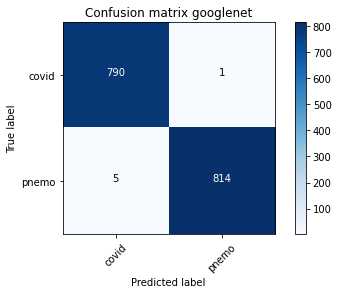

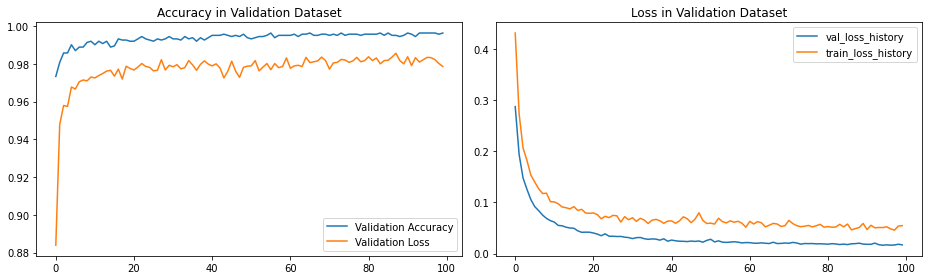


==== END ====
[[789   2]
 [  4 815]]

Sensitivity or recall total
0.9962732919254659

Sensitivity or recall per classes
[1. 1.]

Precision
[0.99 1.  ]

F1 Score
[1. 1.]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> shufflenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.6926 Acc: 0.5132
val Loss: 0.6926 Acc: 0.5186

Epoch 1/99
----------
train Loss: 0.6905 Acc: 0.5537
val Loss: 0.6912 Acc: 0.5335

Epoch 2/99
----------
train Loss: 0.6885 Acc: 0.5461
val Loss: 0.6895 Acc: 0.5075

Epoch 3/99
----------
train Loss: 0.6866 Acc: 0.5304
val Loss: 0.6881 Acc: 0.5199

Epoch 4/99
----------
train Loss: 0.6847 Acc: 0.5253
val Loss: 0.6868 Acc: 0.5012

Epoch 5/99
----------
train Loss: 0.6829 Acc: 0.5426
val Loss: 0.6857 Acc: 0.5304

Epoch 6/99
----------
train Loss: 0.6811 Acc: 0.5463
val Los

train Loss: 0.5531 Acc: 0.9532
val Loss: 0.5755 Acc: 0.9516

Epoch 93/99
----------
train Loss: 0.5522 Acc: 0.9543
val Loss: 0.5847 Acc: 0.9311

Epoch 94/99
----------
train Loss: 0.5513 Acc: 0.9523
val Loss: 0.5814 Acc: 0.9404

Epoch 95/99
----------
train Loss: 0.5486 Acc: 0.9556
val Loss: 0.5654 Acc: 0.9689

Epoch 96/99
----------
train Loss: 0.5480 Acc: 0.9551
val Loss: 0.5652 Acc: 0.9658

Epoch 97/99
----------
train Loss: 0.5466 Acc: 0.9601
val Loss: 0.5734 Acc: 0.9460

Epoch 98/99
----------
train Loss: 0.5458 Acc: 0.9585
val Loss: 0.5754 Acc: 0.9354

Epoch 99/99
----------
train Loss: 0.5446 Acc: 0.9537
val Loss: 0.5740 Acc: 0.9453


##############################
------ Summary ------
model -> shufflenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> SGD
criteriun -> BCELoss

Training complete in 15m 32s
Best val Acc: 0.971429
##############################


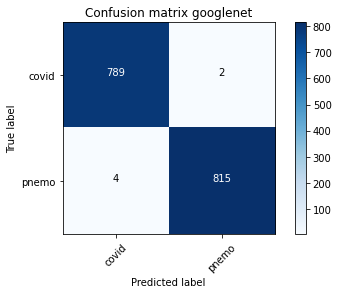

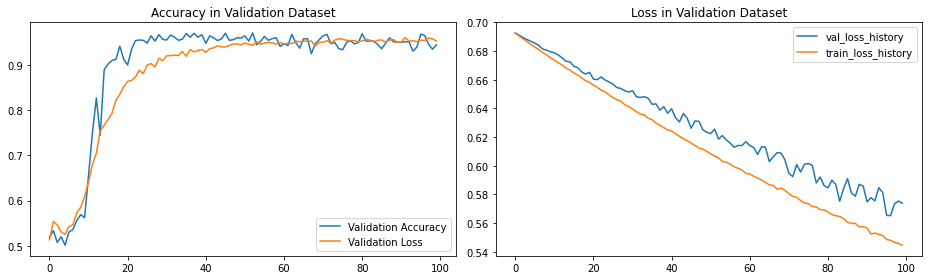


==== END ====
[[769  22]
 [ 24 795]]

Sensitivity or recall total
0.9714285714285714

Sensitivity or recall per classes
[0.97 0.97]

Precision
[0.97 0.97]

F1 Score
[0.97 0.97]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> shufflenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.6704 Acc: 0.5505
val Loss: 0.6594 Acc: 0.5963

Epoch 1/99
----------
train Loss: 0.6268 Acc: 0.8274
val Loss: 0.6206 Acc: 0.9540

Epoch 2/99
----------
train Loss: 0.5872 Acc: 0.9212
val Loss: 0.5954 Acc: 0.9565

Epoch 3/99
----------
train Loss: 0.5523 Acc: 0.9489
val Loss: 0.5679 Acc: 0.9870

Epoch 4/99
----------
train Loss: 0.5207 Acc: 0.9545
val Loss: 0.5452 Acc: 0.9832

Epoch 5/99
----------
train Loss: 0.4911 Acc: 0.9651
val Loss: 0.5218 Acc: 0.9863

Epoch 6/99
----------
train Loss: 0.4643 Acc: 0.9703

val Loss: 0.0986 Acc: 0.9957

Epoch 92/99
----------
train Loss: 0.0797 Acc: 0.9896
val Loss: 0.0937 Acc: 0.9950

Epoch 93/99
----------
train Loss: 0.0854 Acc: 0.9863
val Loss: 0.1076 Acc: 0.9925

Epoch 94/99
----------
train Loss: 0.0804 Acc: 0.9885
val Loss: 0.1076 Acc: 0.9894

Epoch 95/99
----------
train Loss: 0.0792 Acc: 0.9880
val Loss: 0.0967 Acc: 0.9932

Epoch 96/99
----------
train Loss: 0.0816 Acc: 0.9851
val Loss: 0.0802 Acc: 0.9969

Epoch 97/99
----------
train Loss: 0.0801 Acc: 0.9879
val Loss: 0.0905 Acc: 0.9957

Epoch 98/99
----------
train Loss: 0.0808 Acc: 0.9874
val Loss: 0.0940 Acc: 0.9950

Epoch 99/99
----------
train Loss: 0.0801 Acc: 0.9879
val Loss: 0.0955 Acc: 0.9957


##############################
------ Summary ------
model -> shufflenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> ADAM
criteriun -> BCELoss

Training complete in 15m 39s
Best val Acc: 0.996894
##############################


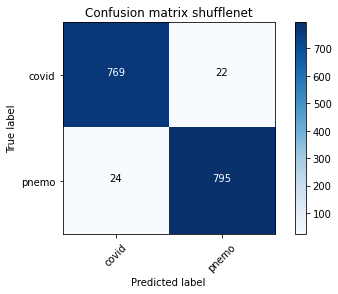

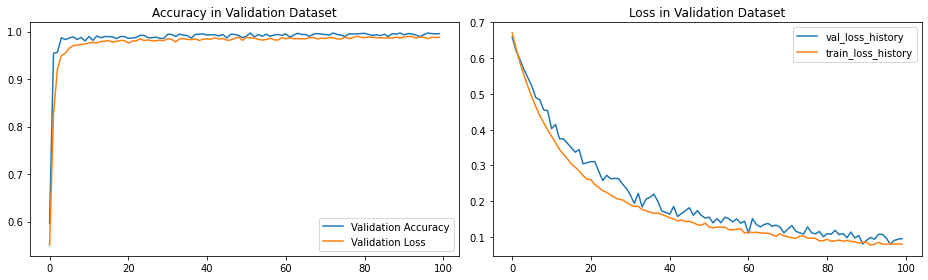


==== END ====
[[787   4]
 [  1 818]]

Sensitivity or recall total
0.9968944099378882

Sensitivity or recall per classes
[0.99 1.  ]

Precision
[1. 1.]

F1 Score
[1. 1.]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> shufflenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.6577 Acc: 0.6570
val Loss: 0.6411 Acc: 0.7186

Epoch 1/99
----------
train Loss: 0.6131 Acc: 0.8319
val Loss: 0.6065 Acc: 0.9627

Epoch 2/99
----------
train Loss: 0.5742 Acc: 0.9327
val Loss: 0.5796 Acc: 0.9702

Epoch 3/99
----------
train Loss: 0.5400 Acc: 0.9466
val Loss: 0.5596 Acc: 0.9795

Epoch 4/99
----------
train Loss: 0.5073 Acc: 0.9612
val Loss: 0.5343 Acc: 0.9870

Epoch 5/99
----------
train Loss: 0.4781 Acc: 0.9664
val Loss: 0.4945 Acc: 0.9876

Epoch 6/99
----------
train Loss: 0.4516 Acc: 0.9682
val Los

train Loss: 0.0819 Acc: 0.9874
val Loss: 0.1017 Acc: 0.9932

Epoch 93/99
----------
train Loss: 0.0882 Acc: 0.9843
val Loss: 0.1026 Acc: 0.9938

Epoch 94/99
----------
train Loss: 0.0839 Acc: 0.9860
val Loss: 0.0855 Acc: 0.9981

Epoch 95/99
----------
train Loss: 0.0783 Acc: 0.9901
val Loss: 0.0891 Acc: 0.9950

Epoch 96/99
----------
train Loss: 0.0848 Acc: 0.9851
val Loss: 0.0831 Acc: 0.9950

Epoch 97/99
----------
train Loss: 0.0790 Acc: 0.9887
val Loss: 0.0901 Acc: 0.9957

Epoch 98/99
----------
train Loss: 0.0827 Acc: 0.9856
val Loss: 0.0860 Acc: 0.9932

Epoch 99/99
----------
train Loss: 0.0761 Acc: 0.9882
val Loss: 0.0905 Acc: 0.9944


##############################
------ Summary ------
model -> shufflenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> RMSprop
criteriun -> BCELoss

Training complete in 15m 36s
Best val Acc: 0.998137
##############################


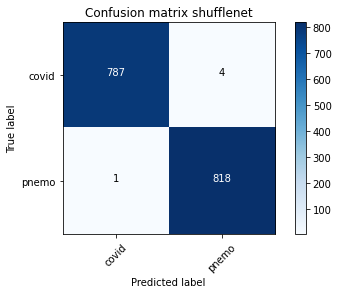

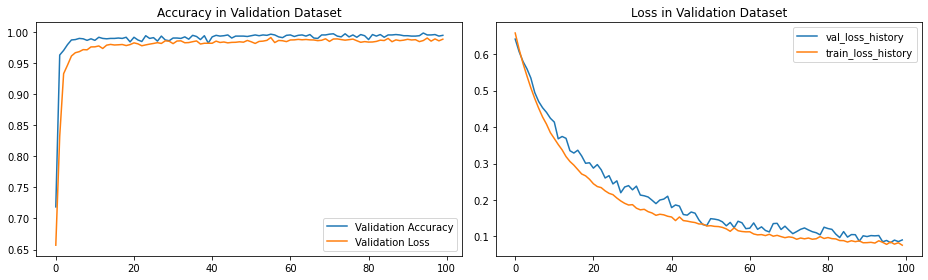


==== END ====
[[789   2]
 [  1 818]]

Sensitivity or recall total
0.9981366459627329

Sensitivity or recall per classes
[1. 1.]

Precision
[1. 1.]

F1 Score
[1. 1.]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> mobilenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.3379 Acc: 0.9102
val Loss: 0.1638 Acc: 0.9876

Epoch 1/99
----------
train Loss: 0.1529 Acc: 0.9772
val Loss: 0.0912 Acc: 0.9938

Epoch 2/99
----------
train Loss: 0.1120 Acc: 0.9837
val Loss: 0.0748 Acc: 0.9938

Epoch 3/99
----------
train Loss: 0.0978 Acc: 0.9823
val Loss: 0.0540 Acc: 0.9957

Epoch 4/99
----------
train Loss: 0.0853 Acc: 0.9828
val Loss: 0.0574 Acc: 0.9932

Epoch 5/99
----------
train Loss: 0.0763 Acc: 0.9843
val Loss: 0.0427 Acc: 0.9944

Epoch 6/99
----------
train Loss: 0.0714 Acc:

val Loss: 0.0057 Acc: 0.9994

Epoch 92/99
----------
train Loss: 0.0231 Acc: 0.9932
val Loss: 0.0060 Acc: 0.9994

Epoch 93/99
----------
train Loss: 0.0248 Acc: 0.9919
val Loss: 0.0086 Acc: 0.9981

Epoch 94/99
----------
train Loss: 0.0301 Acc: 0.9899
val Loss: 0.0083 Acc: 0.9988

Epoch 95/99
----------
train Loss: 0.0244 Acc: 0.9922
val Loss: 0.0056 Acc: 0.9994

Epoch 96/99
----------
train Loss: 0.0277 Acc: 0.9916
val Loss: 0.0060 Acc: 0.9994

Epoch 97/99
----------
train Loss: 0.0252 Acc: 0.9919
val Loss: 0.0056 Acc: 0.9994

Epoch 98/99
----------
train Loss: 0.0334 Acc: 0.9885
val Loss: 0.0060 Acc: 0.9994

Epoch 99/99
----------
train Loss: 0.0262 Acc: 0.9915
val Loss: 0.0049 Acc: 0.9988


##############################
------ Summary ------
model -> mobilenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> SGD
criteriun -> BCELoss

Training complete in 18m 48s
Best val Acc: 1.000000
##############################


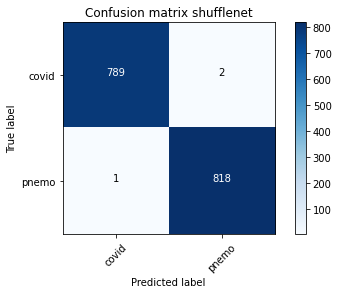

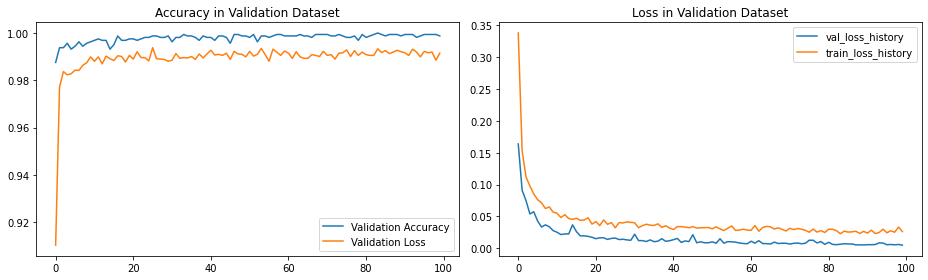


==== END ====
[[791   0]
 [  0 819]]

Sensitivity or recall total
1.0

Sensitivity or recall per classes
[1. 1.]

Precision
[1. 1.]

F1 Score
[1. 1.]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> mobilenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.3234 Acc: 0.9166
val Loss: 0.1348 Acc: 0.9894

Epoch 1/99
----------
train Loss: 0.1414 Acc: 0.9741
val Loss: 0.0750 Acc: 0.9950

Epoch 2/99
----------
train Loss: 0.0994 Acc: 0.9814
val Loss: 0.0550 Acc: 0.9938

Epoch 3/99
----------
train Loss: 0.0792 Acc: 0.9840
val Loss: 0.0420 Acc: 0.9938

Epoch 4/99
----------
train Loss: 0.0635 Acc: 0.9888
val Loss: 0.0351 Acc: 0.9963

Epoch 5/99
----------
train Loss: 0.0583 Acc: 0.9870
val Loss: 0.0274 Acc: 0.9969

Epoch 6/99
----------
train Loss: 0.0535 Acc: 0.9876
val Los

train Loss: 0.0154 Acc: 0.9943
val Loss: 0.0018 Acc: 1.0000

Epoch 93/99
----------
train Loss: 0.0203 Acc: 0.9929
val Loss: 0.0023 Acc: 0.9994

Epoch 94/99
----------
train Loss: 0.0138 Acc: 0.9966
val Loss: 0.0020 Acc: 1.0000

Epoch 95/99
----------
train Loss: 0.0197 Acc: 0.9935
val Loss: 0.0018 Acc: 1.0000

Epoch 96/99
----------
train Loss: 0.0143 Acc: 0.9950
val Loss: 0.0023 Acc: 0.9994

Epoch 97/99
----------
train Loss: 0.0184 Acc: 0.9924
val Loss: 0.0018 Acc: 1.0000

Epoch 98/99
----------
train Loss: 0.0189 Acc: 0.9922
val Loss: 0.0018 Acc: 1.0000

Epoch 99/99
----------
train Loss: 0.0198 Acc: 0.9929
val Loss: 0.0017 Acc: 1.0000


##############################
------ Summary ------
model -> mobilenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> ADAM
criteriun -> BCELoss

Training complete in 18m 49s
Best val Acc: 1.000000
##############################


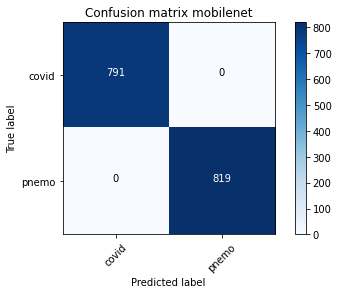

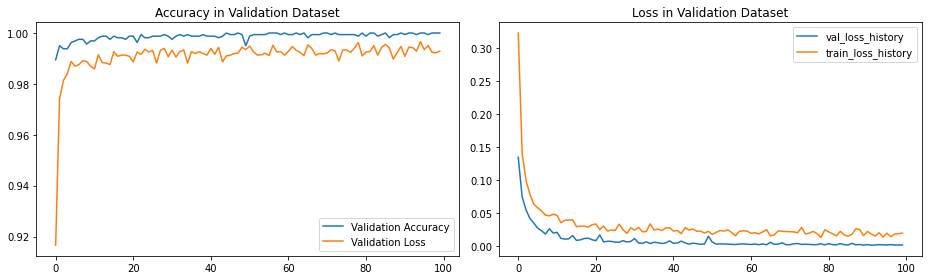


==== END ====
[[791   0]
 [  0 819]]

Sensitivity or recall total
1.0

Sensitivity or recall per classes
[1. 1.]

Precision
[1. 1.]

F1 Score
[1. 1.]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> mobilenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/99
----------
train Loss: 0.2419 Acc: 0.9512
val Loss: 0.1036 Acc: 0.9944

Epoch 1/99
----------
train Loss: 0.1134 Acc: 0.9812
val Loss: 0.0570 Acc: 0.9969

Epoch 2/99
----------
train Loss: 0.0816 Acc: 0.9834
val Loss: 0.0380 Acc: 0.9944

Epoch 3/99
----------
train Loss: 0.0677 Acc: 0.9854
val Loss: 0.0320 Acc: 0.9950

Epoch 4/99
----------
train Loss: 0.0545 Acc: 0.9876
val Loss: 0.0230 Acc: 0.9969

Epoch 5/99
----------
train Loss: 0.0542 Acc: 0.9846
val Loss: 0.0195 Acc: 0.9975

Epoch 6/99
----------
train Loss: 0.0470 Acc: 0.9882
val Los

train Loss: 0.0261 Acc: 0.9908
val Loss: 0.0026 Acc: 0.9994

Epoch 93/99
----------
train Loss: 0.0178 Acc: 0.9930
val Loss: 0.0023 Acc: 1.0000

Epoch 94/99
----------
train Loss: 0.0182 Acc: 0.9939
val Loss: 0.0022 Acc: 0.9994

Epoch 95/99
----------
train Loss: 0.0194 Acc: 0.9927
val Loss: 0.0067 Acc: 0.9975

Epoch 96/99
----------
train Loss: 0.0191 Acc: 0.9925
val Loss: 0.0014 Acc: 1.0000

Epoch 97/99
----------
train Loss: 0.0161 Acc: 0.9941
val Loss: 0.0016 Acc: 1.0000

Epoch 98/99
----------
train Loss: 0.0164 Acc: 0.9944
val Loss: 0.0042 Acc: 0.9994

Epoch 99/99
----------
train Loss: 0.0160 Acc: 0.9952
val Loss: 0.0020 Acc: 0.9994


##############################
------ Summary ------
model -> mobilenet
epochs -> 100
lr -> 0.0001
batch size -> 16
optimizer -> RMSprop
criteriun -> BCELoss

Training complete in 18m 50s
Best val Acc: 1.000000
##############################


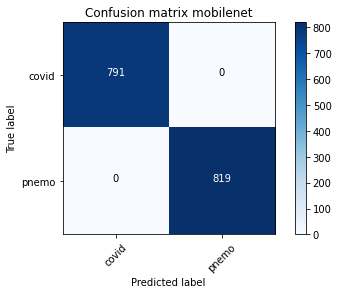

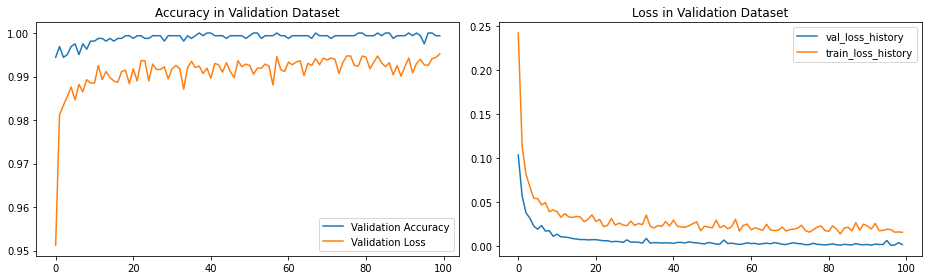


==== END ====
[[791   0]
 [  0 819]]

Sensitivity or recall total
1.0

Sensitivity or recall per classes
[1. 1.]

Precision
[1. 1.]

F1 Score
[1. 1.]
Confusion matrix, without normalization


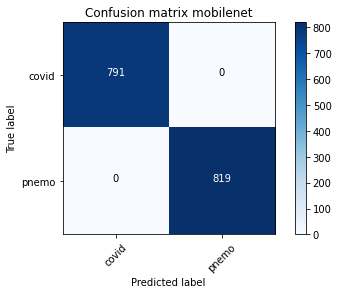

In [23]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
num_classes = 2

_models = ['squeezenet', 'densenet', 'resnet', 'alexnet', 'vgg', 'googlenet', 'shufflenet', 'mobilenet']
lrs = [1e-4]
_epoch = [100]
batch_sizes = [16]
opt = [1, 2, 3]
crt = [1]

for _model in _models:
    for _epochs in _epoch:
        for _lrs in lrs:
            for _batch in batch_sizes:
                for _opt in opt:
                    for _crt in crt:
                               
                        print()
                        print('='*60)
                        print('==== INITIALIZING WITH PARAMETERS: ====')
                        print(f'model -> {_model}')
                        print(f'epochs -> {_epochs}')
                        print(f'lr -> {_lrs}')
                        print(f'batch size -> {_batch}')
                        print(f'optimizer -> {_opt}')
                        print(f'criteriun -> {_crt}')
                        print()

                        feature_extract = True

                        model_ft, input_size = initialize_model(_model, num_classes, 
                                                                feature_extract, use_pretrained=True)

                        # Send the model to GPU
                        model_ft = model_ft.to(device)

                        print('-'*20)
                        params_to_update = model_ft.parameters()
                        print("Params to learn:")
                        if feature_extract:
                            params_to_update = []
                            for name,param in model_ft.named_parameters():
                                if param.requires_grad == True:
                                    params_to_update.append(param)
                                    print("\t",name)

                        else:
                            for name,param in model_ft.named_parameters():
                                if param.requires_grad == True:
                                    print("\t",name)


                        print()
                        print('-'*20)
                        print()
                        print('== Epochs ==')

                        if _opt == 1:
                            optimizer_ft = optim.SGD(params_to_update, _lrs, momentum=0.9)
                            opt_name = 'SGD'

                        if _opt == 2:
                            optimizer_ft = optim.Adam(params_to_update, _lrs)
                            opt_name = 'ADAM'
                            
                        if _opt == 3:
                            optimizer_ft = optim.RMSprop(params_to_update, _lrs)
                            opt_name = 'RMSprop'


                        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

                        #tray nn.NLLLoss
                        if _crt == 1:
                            criterion = nn.CrossEntropyLoss() #BCELoss() CrossEntropyLoss
                            crt_name = 'BCELoss'
                        if _crt == 2:
                            criterion = nn.CrossEntropyLoss()
                            crt_name = 'BCELoss'

                        model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft,
                                                num_epochs=_epochs, model_name=_model, lr=_lrs,
                                                batch_size=_batch, opt_name=opt_name, crt_name=crt_name)

                        from sklearn.metrics import confusion_matrix

                        nb_classes = 2

                        # Initialize the prediction and label lists(tensors)
                        predlist=torch.zeros(0,dtype=torch.long, device='cpu')
                        lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

                        with torch.no_grad():
                            for i, (inputs, classes) in enumerate(dataloaders['val']):
                                inputs = inputs.to(device) #labels atuais
                                classes = classes.to(device) #classes
                                outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
                                _, preds = torch.max(outputs, 1) #pega o maior valor das predições

                                # Append batch prediction results
                                predlist=torch.cat([predlist,preds.view(-1).cpu()])
                                lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

                        # Confusion matrix
                        conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
                        print(conf_mat)
                        print()

                        from sklearn import metrics

                        #analise dos resultados do modelo
                        print('Sensitivity or recall total')
                        print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average='micro'))

                        print()
                        print('Sensitivity or recall per classes')
                        print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average=None))

                        print()
                        print('Precision')
                        print (metrics.precision_score(lbllist.numpy(), predlist.numpy(), average=None))

                        print()
                        print('F1 Score')
                        print (metrics.f1_score(lbllist.numpy(), predlist.numpy(), average=None))

                        cm = confusion_matrix(lbllist.numpy(), predlist.numpy())
                        np.set_printoptions(precision=2)

                        plt.figure()

                        plot_confusion_matrix(cm, classes=['covid', 'pnemo'], 
                        title='Confusion matrix '+_model)




Os resultados na matriz de confuzão e scores estão ruins, provavelmente pelo param.requires_grad = True 

Testar depois com False

**Peguei o código original**

In [ ]:
print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
########## CAM try 1

In [ ]:
# # hook the feature extractor
# features_blobs = []
# def hook_feature(module, input, output):
#     features_blobs.append(output.data.cpu().numpy())

# model_ft._modules.get(finalconv_name).register_forward_hook(hook_feature)

# # get the softmax weight
# params = list(model_ft.parameters())
# weight_softmax = np.squeeze(params[-2].data.numpy())

# def returnCAM(feature_conv, weight_softmax, class_idx):
#     # generate the class activation maps upsample to 256x256
#     size_upsample = (256, 256)
#     bz, nc, h, w = feature_conv.shape
#     output_cam = []
#     for idx in class_idx:
#         cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
#         cam = cam.reshape(h, w)
#         cam = cam - np.min(cam)
#         cam_img = cam / np.max(cam)
#         cam_img = np.uint8(255 * cam_img)
#         output_cam.append(cv2.resize(cam_img, size_upsample))
#     return output_cam


In [ ]:
# normalize = transforms.Normalize(
#    mean=[0.485, 0.456, 0.406],
#    std=[0.229, 0.224, 0.225]
# )
# preprocess = transforms.Compose([
#    transforms.Resize((224,224)),
#    transforms.ToTensor(),
#    normalize
# ])

# response = requests.get(IMG_URL)
# img_pil = Image.open(io.BytesIO(response.content))
# img_pil.save('test.jpg')

# img_tensor = preprocess(img_pil)
# img_variable = Variable(img_tensor.unsqueeze(0))
# logit = model_ft(img_variable)

# # download the imagenet category list
# # classes = {int(key):value for (key, value)
# #           in requests.get(LABELS_URL).json().items()}

# # h_x = F.softmax(logit, dim=1).data.squeeze()
# # probs, idx = h_x.sort(0, True)
# # probs = probs.numpy()
# # idx = idx.numpy()

# # # output the prediction
# # for i in range(0, 5):
# #     print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

# # generate class activation mapping for the top1 prediction
# CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

# # render the CAM and output
# # print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
# img = cv2.imread('test.jpg')
# height, width, _ = img.shape
# heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
# result = heatmap * 0.3 + img * 0.5
# cv2.imwrite('CAM.jpg', result)

In [ ]:
# import IPython.display as display
# from PIL import Image
# image_path = 'CAM.jpg'
# display.display(Image.open(image_path))

In [ ]:
########## CAM try 1 FIIMMMM

In [ ]:
from sklearn.metrics import confusion_matrix

nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device) #labels atuais
        classes = classes.to(device) #classes
        outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
        _, preds = torch.max(outputs, 1) #pega o maior valor das predições

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)
print()


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.405])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    #plt.pause(1)  # pause a bit so that plots are updated

In [ ]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, (inputs, classes) in enumerate(dataloaders['test']):
        #inputs, labels = data

        #inputs, labels = Variable(inputs), Variable(labels)
        inputs = inputs.to(device) #labels atuais
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.figure(figsize=(20,20))
            ax = plt.subplot(5, 2, images_so_far)
            ax.axis('off')
            ax.set_title('{}'.format(class_names[predlist[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

#print(dir(model))
visualize_model(model_ft)

In [ ]:
# savePath = "test_model.pth"
# torch.save(model_ft.state_dict(), savePath)

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
#TRY CAM
#do it using RESNET

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import PIL
import scipy.ndimage as nd
from torch.autograd import Variable

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
#transforms.RandomRotation(degrees=(-5, 5)),
#transforms.ColorJitter(brightness=.02),
    
transformers = {
    'train_transforms': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'test_transforms': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'valid_transforms': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

trans = ['train_transforms','valid_transforms','test_transforms']

path = '/home/jimi/dissertacao/covid19/datasets/bin_80_20/'
categories = ['train','val','test']
dset = {x : torchvision.datasets.ImageFolder(path+x,
                                             transform=transformers[y]) for x,y in zip(categories, trans)}

dataset_sizes = ['train']


num_threads = 4 
dataloaders =  {x : torch.utils.data.DataLoader(dset[x], batch_size=16, shuffle=True, num_workers=num_threads)
               for x in categories}

dataset_sizes = {x : len(dset[x]) for x in ['train','val','test']}

class_names = dset['train'].classes

#class_names = image_datasets['train'].classes

# Detect if we have a GPU available
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
##### RESNET
##Build model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = torchvision.models.resnet152(pretrained=True)
        self.classifier = nn.Sequential(
            nn.Linear(self.model.fc.in_features,2),
            nn.LogSoftmax(dim=1)
        )
        for params in self.model.parameters():
            params.requires_grad = True
        self.model.fc = self.classifier
        
    def forward(self, x):
        return self.model(x)
    
    def fit(self, dataloaders, num_epochs):
        train_on_gpu = torch.cuda.is_available()
        optimizer = optim.Adam(self.model.fc.parameters())
        scheduler = optim.lr_scheduler.StepLR(optimizer, 4)
        criterion = nn.NLLLoss()
        since = time.time()
        
        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc = 0.0
        
        if train_on_gpu:
            self.model = self.model.cuda()
            
        for epoch in range(1, num_epochs+1):
            print("epoch {}/{}".format(epoch, num_epochs))
            print("-" * 10)
            
            for phase in ['train','val']:
                if phase == 'train':
                    scheduler.step()
                    self.model.train()
                else:
                    self.model.eval()
                
                running_loss = 0.0
                running_corrects = 0.0
                
                for inputs, labels in dataloaders[phase]:
                    if train_on_gpu:
                        inputs = inputs.cuda()
                        labels = labels.cuda()
                    optimizer.zero_grad()
                    
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print("{} loss:  {:.4f}  acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
                
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model.state_dict())
        
        time_elapsed = time.time() - since
        print('time completed: {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 600))
        print("best val acc: {:.4f}".format(best_acc))
        
        self.model.load_state_dict(best_model_wts)
        return self.model
    
model = Model()
model_ft = model.fit(dataloaders,50)

from sklearn.metrics import confusion_matrix

nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device) #labels atuais
        classes = classes.to(device) #classes
        outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
        _, preds = torch.max(outputs, 1) #pega o maior valor das predições

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)
print()


from sklearn import metrics

#analise dos resultados do modelo
print('Sensitivity or recall total')
print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average='micro'))

print()
print('Sensitivity or recall per classes')
print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average=None))

print()
print('Precision')
print (metrics.precision_score(lbllist.numpy(), predlist.numpy(), average=None))

print()
print('F1 Score')
print (metrics.f1_score(lbllist.numpy(), predlist.numpy(), average=None))




epoch 1/50
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train loss:  0.1155  acc: 0.9638
val loss:  0.0313  acc: 0.9932
epoch 2/50
----------
train loss:  0.0694  acc: 0.9748
val loss:  0.0225  acc: 0.9919
epoch 3/50
----------
train loss:  0.0461  acc: 0.9820
val loss:  0.0195  acc: 0.9938
epoch 4/50
----------
train loss:  0.0326  acc: 0.9894
val loss:  0.0151  acc: 0.9957
epoch 5/50
----------
train loss:  0.0243  acc: 0.9924
val loss:  0.0174  acc: 0.9950
epoch 6/50
----------
train loss:  0.0269  acc: 0.9921
val loss:  0.0254  acc: 0.9907
epoch 7/50
----------
train loss:  0.0335  acc: 0.9873
val loss:  0.0175  acc: 0.9919
epoch 8/50
----------
train loss:  0.0244  acc: 0.9919
val loss:  0.0232  acc: 0.9894
epoch 9/50
----------
train loss:  0.0257  acc: 0.9905
val loss:  0.0113  acc: 0.9975
epoch 10/50
----------
train loss:  0.0246  acc: 0.9925
val loss:  0.0081  acc: 0.9988
epoch 11/50
----------
train loss:  0.0199  acc: 0.9938
val loss:  0.0123  acc: 0.9963
epoch 12/50
----------
train loss:  0.0260  acc: 0.9916
val loss:  0.0140 

In [5]:
from sklearn.metrics import confusion_matrix

nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device) #labels atuais
        classes = classes.to(device) #classes
        outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
        _, preds = torch.max(outputs, 1) #pega o maior valor das predições

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)
print()


[[789   2]
 [  0 819]]



In [6]:
import itertools 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')





Confusion matrix, without normalization


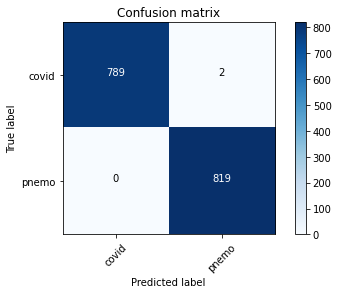

In [7]:
cm = confusion_matrix(lbllist.numpy(), predlist.numpy())
np.set_printoptions(precision=2)

plt.figure()

plot_confusion_matrix(cm, classes=['covid', 'pnemo'], title='Confusion matrix')

In [8]:
data_dir_test = '/home/jimi/dissertacao/covid19/datasets/bin_80_20/test'

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      #transforms.Normalize([0.485, 0.456, 0.406],
                                      #                     [0.229, 0.224, 0.225])
                                     ])

In [9]:
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
#print(model)

In [11]:
#print(model_ft)

In [10]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [11]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir_test, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data,sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

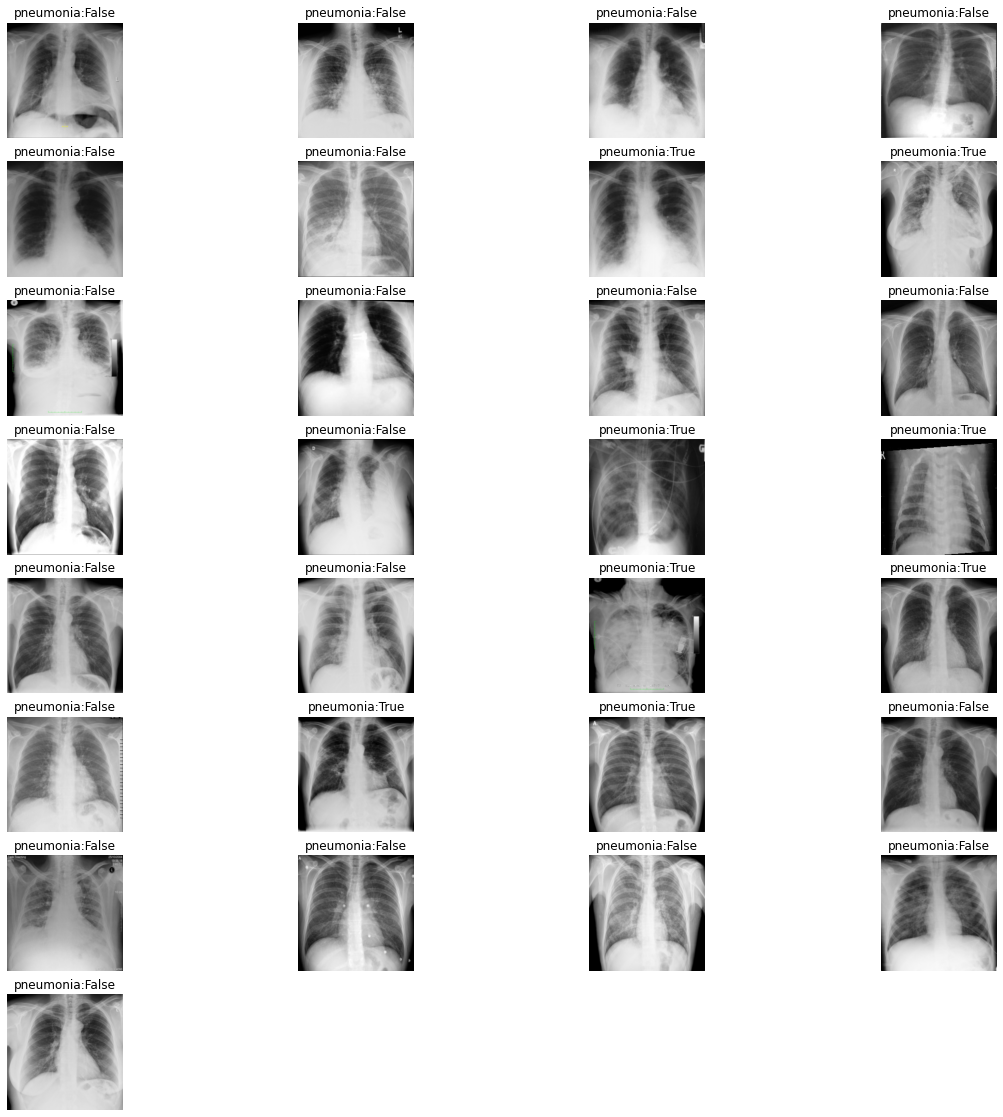

In [14]:
# plot predictions
to_pil = transforms.ToPILImage()
images, labels = get_random_images(30)
fig=plt.figure(figsize=(20,20))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    
    data = datasets.ImageFolder(data_dir_test, transform=test_transforms)
    classes = data.classes
    
    #print (f'index: {index}')
    #print (f'image: {image}')
    #print (f'labes: {labels}')
    #print (f'classes index :{classes[index]}')
    #print (f'classes 2:{classes}')
    
    sub = fig.add_subplot(8, 4, ii+1)
    
    #print()
    res = int(labels[ii]) == 1
    #print(f'int(labels[ii]): {int(labels[ii])}')
    #print(f'index: {index}')
    #print(f'res = int(labels[ii]) == index: {res}')
    #print()
    
    #print (f'res : {res}')
    
    sub.set_title(str(classes[1]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [12]:
loader = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
def image_loader(image_name):
    image = PIL.Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = image.unsqueeze(0)
    return image

In [13]:
class LayerActivations():
    features=[]
    def __init__(self,model):
        self.hooks = []
        self.hooks.append(model.layer4.register_forward_hook(self.hook_fn))
    def hook_fn(self,module,input,output):
        self.features.append(output)
    def remove(self):
        for hook in self.hooks:
            hook.remove()

Text(0.5, 1.0, 'covid')

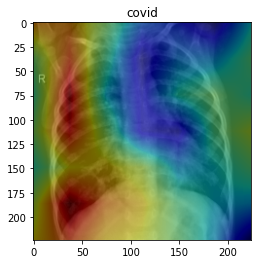

In [46]:
image_path = '/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (620).png'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=2)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


Text(0.5, 1.0, 'covid')

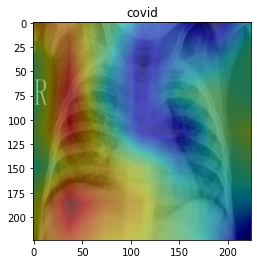

In [50]:
image_path = '/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (521).png'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=2)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [56]:
image_path = '/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (998).png'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=2)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 7.93 GiB total capacity; 7.07 GiB already allocated; 3.75 MiB free; 7.30 GiB reserved in total by PyTorch)

Text(0.5, 1.0, 'covid')

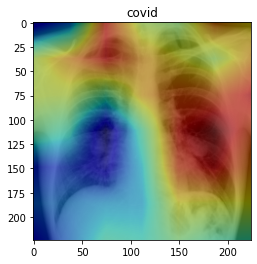

In [15]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/test/covid/000001.png'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=2)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


Text(0.5, 1.0, 'covid')

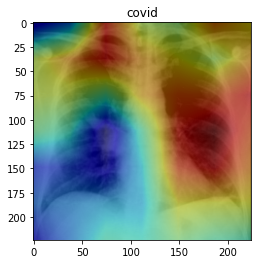

In [16]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/test/covid/000001-9-a.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=2)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


Text(0.5, 1.0, 'covid')

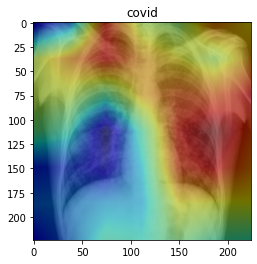

In [17]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/test/covid/000001-10.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=2)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
########## CAM try 2 FIIMMMM

In [ ]:
########## CAM try 2 FIIMMMM

In [22]:
########## CAM try 2 FIIMMMM

In [ ]:
########## CAM try 3 ref - https://github.com/ironWolf1990/pytorch-covid19

In [ ]:
########## CAM try 3 ref- https://github.com/ironWolf1990/pytorch-covid19

In [ ]:
########## CAM try 3 ref

In [ ]:
########## CAM try 3 ref- https://github.com/ironWolf1990/pytorch-covid19
########## CAM try 3 ref
########## CAM try 3 ref
########## CAM try 3 ref

In [ ]:
# utils.py

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, gridspec
from sklearn.manifold import TSNE


def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        cmap = cm.get_cmap("rainbow")
        c = cmap(int(255 * s / 9))
        plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max())
    plt.ylim(Y.min(), Y.max())
    plt.show()
    plt.pause(0.01)

def data_viz(layer, label):
    # https://github.com/MorvanZhou/PyTorch-Tutorial/blob/master/tutorial-contents-notebooks/401_CNN.ipynb
    tsne = TSNE(perplexity=30, n_components=2, init="pca", n_iter=5000)
    plot_only = 500
    low_dim_embs = tsne.fit_transform(layer.data.numpy()[:plot_only, :])
    labels = label.numpy()[:plot_only]
    plot_with_labels(low_dim_embs, labels)


def plot_test_image_result(img, ps, le, cam=None):

    _ = plt.figure(figsize=(8, 6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])

    if cam is not None:
        ax1.imshow(cam, alpha=0.6)
        ax1.imshow(img, alpha=0.4)
    else:
        ax1.imshow(img)

    ax2.barh(np.arange(len(ps)), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(len(ps)))

    for i, v in enumerate(ps):
        ax2.text(
            .01,
            i-0.1,
            f'{v:.3f}',
            color='blue',
            fontweight='bold')

    if le is None:
        ax2.set_yticklabels(np.arange(len(ps)))
    else:
        ax2.set_yticklabels(le.inverse_transform(np.arange(len(ps))))

    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

In [ ]:
# makedataset.py

from os.path import isfile, join
from os import walk
import pandas as pd
import numpy as np
from itertools import tee

from sklearn.model_selection import train_test_split

if __name__ == "__main__":

    path = "./data"
    sample_per_category = 500
    seed = 24
    split_frac = 0.20

    df_raw = None

    genFiles = (
        (dirpath, dirnames, filenames) for (dirpath, dirnames, filenames) in walk(path)
    )

    files, genFiles = tee(genFiles)
    file_count = sum(len(f) for _, _, f in files)

    df_raw = pd.DataFrame(
        data=np.nan, index=np.arange(0, file_count - 1), columns=["LABEL", "FILE"]
    )

    files, genFiles = tee(genFiles)
    idx = 0
    for r, _, f in files:
        for _f in f:
            if isfile(join(r, _f)) and _f.endswith(
                (".jpeg", ".png", "jpg", ".JPEG", ".PNG", "JPG")
            ):
                path = "/".join((r, _f))
                *_, label = r.split("/")
                df_raw.iloc[idx] = [label, path]
                idx += 1

    df_raw.to_csv("./data/raw.csv", index=False)

    # # 3-class
    df_main = pd.DataFrame(
        data=np.nan,
        index=np.arange(0, sample_per_category * 3),
        columns=["FILE", "LABEL"],
    )

    df_main = df_raw.groupby("LABEL").apply(
        lambda s: s.sample(n=min(len(s), sample_per_category), random_state=seed)
    )

    train_df, test_df = train_test_split(
        df_main, random_state=seed, test_size=split_frac, shuffle=True
    )

    train_df.to_csv("./data/3_class_train_df.csv", index=False)
    test_df.to_csv("./data/3_class_test_df.csv", index=False)

    print(f"\n3_class_train_df:\n{train_df['LABEL'].value_counts()}")
    print(f"3_class_test_df:\n{test_df['LABEL'].value_counts()}")

    # 2-class
    df_main = pd.DataFrame(
        data=np.nan,
        index=np.arange(0, sample_per_category * 2),
        columns=["FILE", "LABEL"],
    )

    index = df_raw[df_raw["LABEL"] == "pneumonia"].index
    df_raw.drop(index, inplace=True)

    df_main = df_raw.groupby("LABEL").apply(
        lambda s: s.sample(n=min(len(s), sample_per_category), random_state=seed)
    )

    train_df, test_df = train_test_split(
        df_main, random_state=seed, test_size=split_frac, shuffle=True
    )

    train_df.to_csv("./data/2_class_train_df.csv", index=False)
    test_df.to_csv("./data/2_class_test_df.csv", index=False)

    print(f"\n2_class_train_df:\n{train_df['LABEL'].value_counts()}")
    print(f"2_class_test_df:\n{test_df['LABEL'].value_counts()}")

In [ ]:
# architectures.py

import torch.nn as nn
from torchvision.models import resnet50


class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


class Rn50(nn.Module):
    def __init__(self, device, train_base=False, classes=2):
        super(Rn50, self).__init__()

        self.device = device

        self.net_back = resnet50(pretrained=True).to(self.device)
        self._trainable(train_base)

        fc_size = self.net_back.fc.in_features
        self.net_back.fc = Identity()

        self.net_head = nn.Sequential(
            nn.Linear(in_features=fc_size, out_features=1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=512, out_features=classes),
            nn.LogSoftmax(dim=1),
        ).to(self.device)

    def forward(self, x):
        x = self.net_back(x.to(self.device))
        x = x.view(x.size(0), -1)
        return self.net_head(x.to(self.device))

    def _trainable(self, flag):
        for param in self.net_back.parameters():
            param.requires_grad = flag


# old way
# modules = list(resnet50(pretrained=True).children())[:-1]
# self.net_back = nn.Sequential(*modules).to(self.device)
# fc_size = list(self.net_back.parameters())[-1].size(0)
# self.net_head = nn.Sequential(...).to(self.device)

In [ ]:
# activationmap.py

import torch


class FeatureBuffer():

    features=None

    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        # self.features = ((output.cpu()).data).numpy()
        self.features = output

    def remove(self):
        self.hook.remove()


# def GradCam(model, input_image_tensor):

#     https://github.com/tyui592/class_activation_map/blob/master/cam.py
#     https://github.com/daixiangzi/Grad_Cam-pytorch-resnet50/blob/578db29d13b0e7d17aa53d9bac116674771618ec/test_grad_cam.py#L19
#     https://snappishproductions.com/blog/2018/01/03/class-activation-mapping-in-pytorch.html.html
#     https://github.com/MarcoCBA/Class-Activation-Maps-PyTorch/blob/master/class_activation_maps.ipynb

#     print(model)

#     final_conv_layer = model.net_back._modules.get('layer4')
#     fc_layer = model.net_head._modules.get('0')
#     fb = FeatureBuffer(final_conv_layer)

#     model = model.eval()
#     out = model(input_image_tensor)

#      # based on model caluculate output!!!
#     probabilities = torch.exp(out)
#     _, predicted = torch.max(probabilities, 1)
#     feature_maps = fb.features

#     print("Output's shape: ", out.shape)
#     print("Feature maps's shape: ", feature_maps.shape)

#     weights_and_biases = list(fc_layer.parameters())
#     class_weights = weights_and_biases[0][predicted]
#     print("Weights's shape: ", weights_and_biases[0].shape)
#     print("Biases's shape: ", weights_and_biases[1].shape)
#     print("Class weights's shape :", class_weights.shape)

#     class_weights = class_weights.reshape((-1, 1, 1))
#     feature_maps = feature_maps.flatten(start_dim=0, end_dim=1)
#     print("Class weights's shape :", class_weights.shape)
#     print("Feature maps's shape: ", feature_maps.shape)

#     class_activation_maps = np.array(torch.sum(feature_maps * class_weights, dim=0).detach(), dtype=np.float32)
#     plt.figure(figsize=(6, 6))
#     plt.imshow(class_activation_maps)
#     plt.show()

#     resized_cam = cv2.resize(class_activation_maps, dsize=(224, 224), interpolation=cv2.INTER_LANCZOS4)
#     plt.figure(figsize=(6, 6))
#     plt.imshow(resized_cam)
#     plt.show()

In [ ]:
# train.py

import math
from time import time
from copy import deepcopy

import torch

try:
    from torchsummary import summary
except:
    MODELSUMMARY = False
else:
    MODELSUMMARY = True

try:
    from sklearn.manifold import TSNE
except:
    VIZTSNE = False
else:
    VIZTSNE = True


def train_model(
    model,
    device,
    criterion,
    optimizer,
    dataloaders,
    dataloader_len,
    input_shape,
    scheduler=None,
    num_epochs=50,
):

    if MODELSUMMARY:
        summary(model, input_data=input_shape)

    start = time()
    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        t_epoch = time()
        print(f"epoch: {epoch+1}/{num_epochs}")

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for idx, (labels, inputs) in enumerate(dataloaders[phase]):
                iter_batch = math.ceil(
                    dataloader_len[phase] / dataloaders[phase].batch_size
                )
                print(f"[phase: {phase}] batch: {idx+1}/{iter_batch}", end="\r")

                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                if scheduler is not None:
                    scheduler.step()

            epoch_loss = running_loss / dataloader_len[phase]
            epoch_acc = running_corrects.double() / dataloader_len[phase]
            print(f"[phase: {phase}] Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                print(f"[saving model] epoch: {epoch+1} Acc: {epoch_acc:.4f}")
                best_acc = epoch_acc
                best_model_wts = deepcopy(model.state_dict())

        t_elapsed = time() - t_epoch
        print(f"epoch training complete in {t_elapsed//60:.0f}m {t_elapsed%60:.0f}s")
        print()

    time_elapsed = time() - start
    print(f"training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"best val Acc: {best_acc:4f}")

    model.load_state_dict(best_model_wts)

    checkpoint = {
        "input_shape": input_shape,
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }

    torch.save(checkpoint, "./models/checkpoint.pth")
    return model

In [ ]:
# test.py

import math

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from scripts.activationmap import FeatureBuffer
from sklearn.metrics import classification_report, confusion_matrix

#from .utils import plot_test_image_result


def test_model(model, testloader, device, encoder=None):

    correct = 0
    total = 0
    true_list = list()
    pred_list = list()

    for idx, (labels, inputs) in enumerate(testloader):
        iter_batch = math.ceil(len(testloader.dataset)/testloader.batch_size)
        print(f'[phase: test] batch: {idx+1}/{iter_batch}', end='\r')

        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            probabilities = torch.exp(outputs)
            _, predicted = torch.max(probabilities, 1)

            total = idx + 1
            correct += torch.sum(predicted == labels.data)
            true_list.append((labels.data.cpu()).numpy().item())
            pred_list.append((predicted.cpu()).numpy().item())

    acc = 100*(correct.item()/total)
    print(f"[phase: test] total: {total}, correct: {correct}, acc: {acc:.3f}")

    print(classification_report(tuple(true_list), tuple(pred_list)))

    y_true = pd.Series(true_list, name='Actual')
    y_pred = pd.Series(pred_list, name='Predicted')
    cm = pd.crosstab(y_true, y_pred,  margins=True)

    print("confusion matrix")
    if encoder is not None:
        print({i : encoder.classes_[i] for i in range(0, len(encoder.classes_))})
    print(cm)



def test_image(model, image, in_shape, transform, device, labelencoder=None, cam=None):
    """
    GradCam
    """

    if cam is not None:
        final_conv_layer = model.net_back._modules.get('layer4')
        fc_layer = model.net_head._modules.get('0')
        fb = FeatureBuffer(final_conv_layer)

    input_tensor = transform(image).unsqueeze(0)
    inputs = input_tensor.to(device)

    model = model.eval()
    outputs = model(inputs)
    probabilities = torch.exp(outputs)
    prob = (probabilities.cpu()).detach().numpy().flatten()

    if cam is not None:
        _, predicted = torch.max(probabilities, 1)
        feature_maps = fb.features

        weights_and_biases = list(fc_layer.parameters())
        class_weights = weights_and_biases[0][predicted]

        class_weights = class_weights.reshape((-1, 1, 1))
        feature_maps = feature_maps.flatten(start_dim=0, end_dim=1)

        class_activation_maps = np.array(
            torch.sum(feature_maps * class_weights, dim=0).cpu().detach(),
            dtype=np.float32)

        cam_map = cv2.resize(
            class_activation_maps,
            dsize=in_shape,
            interpolation=cv2.INTER_LANCZOS4)

    if cam is not None:
        plot_test_image_result(image.resize(in_shape), prob, labelencoder, cam_map)
    else:
        plot_test_image_result(image, prob, labelencoder)

In [ ]:
# evaluate.py 

import torch
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder

import pandas as pd
from PIL import Image

from scripts.datagen import Datagen
from scripts.architectures import Rn50
from scripts.test import test_model, test_image


def get_device():
    if torch.cuda.is_available():
        return "cuda:0"
    else:
        return "cpu"

test_file = "data/3_class_test_df.csv"
image_file = "data/raw/covid/covid_001.jpg"
num_workers = 2
batch_size = 1
input_shape = (256, 256)
le = LabelEncoder()

df = pd.read_csv(test_file)

test_transforms = transforms.Compose(
    [
        transforms.Resize(input_shape),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

test_set = Datagen(df, l_encoder=le, transforms=test_transforms)
label_enc = test_set.get_le()
device = get_device()

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, num_workers=num_workers,
)

model = Rn50(device=device, classes=3)
model.load_state_dict(torch.load("./models/checkpoint.pth")["state_dict"])

test_model(
    model=model,
    testloader=test_loader,
    device=device,
    encoder=label_enc)

input_image = Image.open(image_file).convert("RGB")
test_image(
    model=model,
    image=input_image,
    in_shape=input_shape,
    transform=test_transforms,
    device=device,
    labelencoder=label_enc,
    cam=True
)

In [ ]:
# datagen.py

from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from PIL import Image


class Datagen(Dataset):
    def __init__(self, dataframe, transforms=None, l_encoder=None):
        self.df = dataframe
        self.transforms = transforms
        self.encoder = l_encoder

        if self.encoder is not None:
            self.df["LABEL"] = self.encoder.fit_transform(self.df["LABEL"])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        label = self.df.iloc[idx, 0]
        image_file = self.df.iloc[idx, 1]
        image = Image.open(image_file).convert("RGB")

        if self.transforms:
            image = self.transforms(image)

        # print(image.shape)
        return (label, image)

    def get_le(self):
        return self.encoder

In [ ]:
# trainer.py

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
from torch.utils.data import SubsetRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pandas as pd

from scripts.datagen import Datagen
from scripts.architectures import Rn50
from scripts.train import train_model


def get_device():
    if torch.cuda.is_available():
        return "cuda:0"
    else:
        return "cpu"


train_file = "data/3_class_train_df.csv"
num_workers = 2
val_split = 0.2
batch_size = 32
num_epochs = 20
input_shape = (3, 256, 256)
le = LabelEncoder()

df = pd.read_csv(train_file)

train_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

validation_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

train_set = Datagen(df, l_encoder=le, transforms=train_transforms)
validation_set = Datagen(df, l_encoder=le, transforms=validation_transforms)

train_idx, val_idx = train_test_split(list(range(len(df))), test_size=val_split)
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(val_idx)

train_loader = torch.utils.data.DataLoader(
    train_set,
    # shuffle=True,
    batch_size=batch_size,
    sampler=train_sampler,
    num_workers=num_workers,
)

valid_loader = torch.utils.data.DataLoader(
    validation_set,
    # shuffle=False,
    batch_size=batch_size,
    sampler=valid_sampler,
    num_workers=num_workers,
)

device = get_device()
net = Rn50(device=device, classes=3)

dataloaders = {"train": train_loader, "val": valid_loader}
dataloader_len = {"train": len(train_idx), "val": len(val_idx)}

criteration = nn.NLLLoss()
optimizer = optim.Adam(net.parameters())
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(
    model=net,
    device=device,
    criterion=criteration,
    optimizer=optimizer,
    dataloaders=dataloaders,
    dataloader_len=dataloader_len,
    input_shape=input_shape,
    num_epochs=num_epochs,
)

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM
########## CAM try 3 FIM
########## CAM try 3 FIM
########## CAM try 3 FIM

In [ ]:
########## CAM functional

In [ ]:
# simple implementation of CAM in PyTorch for the networks such as ResNet, DenseNet, SqueezeNet, Inception

import io
import requests
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2
import pdb

# input image
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
IMG_URL = 'https://diariodonordeste.verdesmares.com.br/image/contentid/policy:1.2966908:1594933666/ferramenta-sesa.jpg'

# networks such as googlenet, resnet, densenet already use global average pooling at the end, so CAM could be used directly.
model_id = 1
if model_id == 1:
    net = models.squeezenet1_1(pretrained=True)
    finalconv_name = 'features' # this is the last conv layer of the network
elif model_id == 2:
    net = models.resnet18(pretrained=True)
    finalconv_name = 'layer4'
elif model_id == 3:
    net = models.densenet161(pretrained=True)
    finalconv_name = 'features'

#net.eval()

In [ ]:
# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

net._modules.get(finalconv_name).register_forward_hook(hook_feature)

# get the softmax weight
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam


In [ ]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))
img_pil.save('test.jpg')

img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0))
logit = net(img_variable) ## aqui tem algo

# # download the imagenet category list
classes = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

h_x = F.softmax(logit, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

# # output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

# render the CAM and output
print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
img = cv2.imread('test.jpg')
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('CAM.jpg', result)

In [ ]:
import IPython.display as display
from PIL import Image
image_path = 'CAM.jpg'
display.display(Image.open(image_path))

In [2]:
import tensorflow as tf
tf.__version__

ModuleNotFoundError: No module named 'tensorflow'

In [3]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

ModuleNotFoundError: No module named 'tensorflow'

In [3]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

GeForce GTX 1080
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)
